<a href="https://colab.research.google.com/github/lchutny/W207_ALSY_FinalProject/blob/master/W207_ALSY_FinalProject_Baseline_R2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FACIAL KEYPOINT DETECTION and PREDICTION USING NEURAL NETS   

## Final Project W207  | Dr. Yacov Solomon | Monday 18:30 Pacific

### Andrew Webb, Laura Chutny, Suzy Choi, and Yue Hu
### 5 August 2019



---



# I. Introduction

Facial recognition has a variety of applications, notably in biometrics. Rather than sign into a phone or laptop, give a username and password for a service, or use some form of document identification, people can use their faces to identify themselves. Similarly, security and police forces can use this type of recognition to match images and identify people in the course of investigations, enabling faster and more accurate identifications. There are other uses including medical diagnostics and analysis of facial expressions that this type of work can also be used for.

As with fingerprints, no two faces are exactly alike, so this is actually a more robust form of identification than usernames, passwords, documents, etc. that can either be forged or stolen. In order to properly leverage facial recognition for identification, however, the key facial features must be detected with a high level of accuracy. Detecting key facial features given images of faces in a variety of contexts is a key aspect of leveraging facial recognition for personal identification. If we can accurately detect the facial keypoints of a given image in a variety of contexts, we can then ensure accurate identification of the person associated with the face. Additionally, this type of model can even identify if the image is not of a human face.

For this project, we will use a variety of Supervised Machine Learning techniques (KNN, Linear Regression, Neural Networks) to detect the facial keypoints, and make identifications. 

Following standard machine learning problem methodology, this paper will follow these steps:  

1.   Inputs, $X$ . In this problem, the inputs are provided by Kaggle, in the Facial Keypoints Detection competition ([https://www.kaggle.com/c/facial-keypoints-detection]). The $X$ inputs consist of vectors of pixels representing images of faces in 96x96 pixel grids.  Details are discussed more in [Section II](https://colab.research.google.com/drive/1lQbest_yYl_irX_aiY574ksZ1a4SyufO#scrollTo=9SYvZA_TX3Dd)

 Inputs, $y$ . Accompanying the training images are labels, some fully and some partially labeled. The labels are the x,y coordinates in the image space for the locations of (up to) 15 facial keypoints.  The labels are continuous values - x,y coordinate pairs - a 15 x 2 array of x,y values for 15 facial keypoints that has been flattened to 1 x 30.

2.   Outputs: From the training data, we will train a model, with the eventual goal to (correctly) predict the location of the facial keypoints ($\hat y$) for an unlabeled image.  

3.  Feature Engineering (Data) and Feature Selection: In [Section III](https://colab.research.google.com/drive/1lQbest_yYl_irX_aiY574ksZ1a4SyufO#scrollTo=1nqq3gpbnYox) the extraction, cleaning and preparation of the data is discussed.  As we are given labels for the training data, this is treated as a supervised learning problem.  

 Feature selection for simpler models is not performed, as the entire image is required to perform the analysis on. This means that given the large number of features (96 x 96 = 9216 pixels) versus the small number of labels (15) the simpler models will likely suffer from the Curse of Dimensionality. However, feature selection is essentially 'automatically' carried out when using Neural Nets for analysis of images, thus no separate feature selection will be performed as part of this project.
 
 Data will be split into Training and Dev sets for the initial model parameter selection and optimization.

4.  Modeling:  In this report, we will compare and contrast the model types discussed in W207. Three types of supervised learning models will be used:  
 * KNN ([Section IV](https://colab.research.google.com/drive/1lQbest_yYl_irX_aiY574ksZ1a4SyufO#))  
 * Linear Regression ([Section V](https://colab.research.google.com/drive/1lQbest_yYl_irX_aiY574ksZ1a4SyufO#scrollTo=AMU0QdgtCs-C)) and   
 * Neural Networks ([Section VI](https://colab.research.google.com/drive/1lQbest_yYl_irX_aiY574ksZ1a4SyufO#scrollTo=pcT1qVjhCipV)).  

 These models will be fit using the training data, and then using the dev data and the cost function, the parameters will be optimized according to the objective function as described in detail in the section(s) for each model.
 
 Finally, in the 'Test' step the test data will be used to evaluate the hyperparameters (if present) and allow for comparison of the accuracy of each of the models.
 
This report will end with conclusions regarding the effectiveness of each type of model along with suggestions for further improvements.

To start, we will import all of the needed modules for this project and show the versions for each of the major project components (python, pandas, numpy, etc.).   Required setup is:  
python version = 3.6.8  
Pandas Version =  0.24.2  
Numpy Version =  1.16.4  
Scikit Learn Version =  0.21.3  
Theano Version =  1.0.4

In [1]:
# Import all of the needed modules
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import time
import sys
import csv
import os

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# Theano imports
import theano 
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
print(theano.config.device) # We're using CPUs (for now)
print(theano.config.floatX) # Should be 64 bit for CPUs
np.random.seed(0) # Setting random seed


cpu
float64


In [2]:
# show the versions for each of the main dependencies
print("python version =",sys.version)
print("Pandas Version = ",pd.__version__)
print("Numpy Version = ",np.__version__)
print("Scikit Learn Version = ", sklearn.__version__)
print("Theano Version = ", theano.__version__)

python version = 3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]
Pandas Version =  0.24.2
Numpy Version =  1.16.4
Scikit Learn Version =  0.21.3
Theano Version =  1.0.4


In [3]:
# Run this cell to mount your Google Drive - if that is where you want to access your data from
from google.colab import drive
drive.mount('/content/drive')
# Make sure to upload from your local machine and then this path will work

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


<a id='Section_2'></a>
# II. The image data 

The input data, $X$, is a collection of 96x96 pixel images of a face, provided as a flattened 1 x 9216 vector of pixels, with gray scale values ranging from 0-255. The corresponding 'labels' are the seperate x and y coordinates within the image of up to 15 keypoints: centers, inner corners and outer corners of left and right eye (6 x,y labels), inner and outer ends of both eyebrows (4 labels), nose tip (1 label), left and right corners of the mouth (2 labels) and centers of top and bottoms lips (2 labels). Note that here, left and right refer to the point of view of the subject.


Training data is provided from Kaggle as a CSV file of 7049 images, both fully and partially labelled. Test data is a similar file of 1783 images only. Issues present in the training data include:   
- Images that are not of people
- Images that are not centered in the frame
- Images that show only 1 side of a person
- Images with variable lighting
- Images that only have partial labels  

Partial labels belong to two categories:  
 1.   *Missing* feature labels - that is, the face is centered but things like left_eyebrow_inner_end are simply not labeled
 2.   *Not Available* labels - that is, the face of the person in the image is facing down, left, right, up, etc. and the feature does not *show* in the photo, therefore cannot be labeled. (i.e. if a person is facing left, some of their left features will not be available)

Some of these issues will be addressed further on in the model sections.  

To view the data, either training or test, we have built a function which transforms the CSV text data into an array format that we can work with. Additionally, as the issue of missing labels seems more prevalent than the unavailable labels, we have added an option to load data that only has complete labels. We can then train a model on the complete data and perhaps use it to "fill-in" missing labels at a later stage.

The below model can be used to load complete or incomplete training/dev data or test data.


In [0]:
# Function to load and tidy up the data

# Update with filepath. Just uncomment the code to get your filepath to work
# Andrew's filepath
#filepath = '/content/drive/My Drive/FinalProject_w207/'
# Suzy's filepath
#filepath = '/content/drive/My Drive/FinalProject_w207/'
# Yue's filepath
#filepath = ''
# Laura's filepath
filepath = '/content/'


def load_data(data_type='train', columns=None, filepath=filepath, data='complete'):
  """Load the data from Kaggle which is contained on your local drive
  A filepath string variable gives the path to the csv data
  
  If data_type = 'train', then load the train data
  If data_type = 'dev', then load the dev data
  If data_type = 'test', then load the test data.
  
  If data = 'complete', then only images with complete labels are returned
  If data = 'incomplete', then only images containing any NaN label values are returned
  If data = any other value, then all images are returned
  
  You can also pass in a list of columns if you only want a subset of labels
  """
  
  # create a DataFrame object with the training.csv data
  # shuffle records in the csv file
  df = shuffle(pd.DataFrame(pd.read_csv(filepath + 'training.csv')),
              random_state = 42) # set a seed for development
  
  # Use the first 6000 records for training
  train_data = df[:6000]
  
  # And the rest for dev
  dev_data = df[6000:]
  
  # Test data
  test_data = pd.DataFrame(pd.read_csv(filepath + 'test.csv'))
  
  if data_type == 'train':
    df = train_data
    
  elif data_type == 'dev':
    df = dev_data
    
  elif data_type == 'test':
    df = test_data
    
  else:
    print('Something went wrong with the train/dev/test data assignment')
    
  # train and dev data will have labels (facial keypoints) as well as an associated image
  # test data only has the image column
  # the image column is a string field delimited by spaces
  # we will split the image column and turn it into a numpy array
  
  # Assign the X variable to the image
  df['Image'] = df['Image'].apply(lambda image: np.fromstring(image, sep=' '))
  
  # if the columns were passed in to the function
  if columns:  
    df = df[list(columns) + ['Image']]
  
  # prints the number of values for each column
  # uncomment to see labels associated with number of images in the dataset
  # print("Number of Values Each Column =\n",df.count())  

  # drop all rows that have missing values in them if data == 'complete'
  # this will ONLY output images that have no unavailable labels 
  # (i.e. no images with faces turned left/right/up/down and no missing values)
  if data == 'complete':
    df = df.dropna() 
    print("Number of rows total after dropping missing valued data =",df.shape[0])
    
  # include only images that have missing or unavailable labels
  # this can be used to help "fill-in" missing values to increase the training set
  elif data == 'incomplete':
    df = df[df.isnull().any(1)]
    print("Number of rows total after dropping completely labeled data =",df.shape[0])
    
  # include all rows of the data
  else:
    print("Number of rows having no data dropped =", df.shape[0])
  
  # scale pixel values to [0, 1]
  X = np.vstack(df['Image'].values) / 255.  
  X = X.astype(np.float32)
  
  # Assign y variable to labels, if applicable (i.e. if we are not using test data)
  if data_type == 'test':
    y = None
  else:
    # set y to equal all but the last column (only the labels, not the image)
    y = df[df.columns[:-1]].values
    # scale target coordinates to [-1, 1] - i.e. center of the image is x=y=0
    y = (y - 48) / 48
    y = y.astype(np.float32)
    
    # Add label_names here for easy output in the project
    label_names = df.columns[:-1].astype(np.str)
    
  return X, y, label_names
  
      

First we will assign variables for the complete training data set

In [5]:
# get train data into X and y and print number of values in each column
train_X, train_y, train_labels = load_data(data_type = 'train', data='complete')
print("Training X shape:",train_X.shape,"Training y shape",train_y.shape)

Number of rows total after dropping missing valued data = 1842
Training X shape: (1842, 9216) Training y shape (1842, 30)


Then we can load the complete dev data

In [6]:
# get dev data into X and y splits and print the same values
dev_X, dev_y, dev_labels = load_data(data_type = 'dev', data='complete')
print("Dev X shape:",dev_X.shape,"Dev y shape",dev_y.shape)

Number of rows total after dropping missing valued data = 298
Dev X shape: (298, 9216) Dev y shape (298, 30)


### Viewing the training data arrays and rendering as images

In order to better understand the data we are using, we will look at an individual array from our complete training data. Here we see that each array has 9216 values, each representing the pixel values for that image. For each value, 0 would be a completely black pixel, 1 would be a completely white pixel, and 0.5 would be an even grey mix of black and white.

In [7]:
# Print a sample of the train data
print(train_X[0])
print(train_X[0].shape)

[0.04705882 0.04705882 0.04313726 ... 0.27058825 0.25490198 0.23529412]
(9216,)


The below shoes the array rendered as a 96x96 pixel image

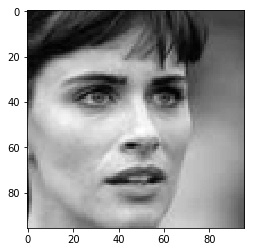

In [8]:
# Print a sample X image from the above data (0 is black, 1 is white)
img = train_X[0].reshape(96,96)
plt.imshow(img, cmap='gray') 

The labels, too, are represented as an array which can be overlaid on top of the image. Given an image, our goal is to predict the labels (x and y coordinates) associated with the facial key points. This is a supervised learning problem where given an image, $X$, we would like to predict the 15 specific facial keypoint locations, $\hat{Y}$

In [9]:
# Print a sample of y label data. x,y = 0,0 is the center of the image.
keypoints_1 = train_y[0:1,:]
print(keypoints_1)
print(keypoints_1.shape, type(keypoints_1))

[[ 0.261807   -0.20208012 -0.34046057 -0.20353137  0.13390376 -0.17920847
   0.39397693 -0.18342675 -0.22617969 -0.16135813 -0.5313947  -0.15987785
   0.11421517 -0.31416225  0.4764021  -0.3693298  -0.10285714 -0.34354496
  -0.6637912  -0.31978694  0.1138322   0.21350466  0.2699293   0.55108494
  -0.2746109   0.5821255   0.04251724  0.51590264  0.02736945  0.60252357]]
(1, 30) <class 'numpy.ndarray'>


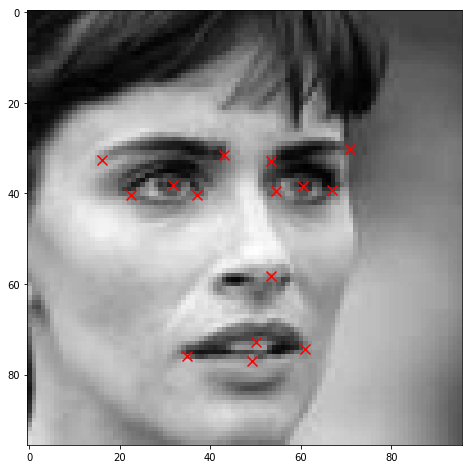

In [10]:
# print the sample image with the training 'labels' - keypoint indices marked on image.
# process y data into 2 columns - first is x and second is y for plotting points
keypoints_2 = keypoints_1.reshape(15,2)

# we normalized the keypoint locations, but to plot we need to 'un-normalize'
keypoints_3 = keypoints_2*48 + 48

# Plot
plt.figure(figsize=(8,8))
plt.imshow(img,cmap='gray')
plt.scatter(keypoints_3[:,0],keypoints_3[:,1],c='r',marker="x", s=100)
plt.show()

# III. Data Preparation / Feature Engineering

In order to prepare the data for our modeling, we will experiment with a few methods of transforming the image data. (Feature Engineering)

a) Blurring the pixels  
b) Accentuating the images  
c) Flipping (Reversing) the images and labels

## a) and b) Blur and accentuate images for better feature classification

One of the things we would like to address is the complex feature space involved in taking images and classifing the facial keypoints. We have 30 labels we would like to predict given the image data (x and y coordinates for 15 facial keypoints) and we are using arrays with 9216 features to train our models. The variability in each of these features can be reduced by blurring the images (i.e. transforming each pixel value to be the weighted average of the surrounding pixel values) and accentuating the light and dark aspects of the image.

In [0]:
def Gaussian_blur(image):
  """Blur each image by Gaussian blur with simplified 9 pixel Gaussian kernel"""
  # create kernel
  kernel = np.array([[1,2,1], [2,4,2], [1,2,1]])
  # create weights by dividing the kernel by the sum of the kernel
  kernel = kernel / np.sum(kernel)

  image = image.reshape(96,96)
  # create a numpy array with values of 1 on the border of matrix 
  # and others are zero
  border_image = np.ones(image.shape)
  border_image[1:-1,1:-1] = 1
  # initialize the blurred image matrix
  image_blur = np.zeros(image.shape)

  # smoothed value of a pixel by a weighted combination of the 
  # original value and the 8 neighboring values
  for i in list(range(1,95,1)):
      for j in list(range(1,95,1)):
          image_blur[i][j] = (image[i-1][j-1]*kernel[0][0]) + (image[i-1][j]*kernel[0][1]) + (image[i-1][j+1]*kernel[0][2])
          + (image[i][j-1]*kernel[1][0]) + (image[i][j]*kernel[1][1]) + (image[i][j+1]*kernel[1][2])
          + (image[i+1][j-1]*kernel[2][0]) + (image[i+1][j]*kernel[2][1]) + (image[i+1][j+1]*kernel[2][2])

  # Keep value on the border of image matrix and update other value by a
  # weighted combination of the original value and the 8 neighboring values        
  return (image_blur + image*border_image).reshape(9216,)
  
def Blur_image(data):
  """Blur all images in data with Gaussian Blur"""
  blur_image1 = np.empty(data.shape)
  for k in range(data.shape[0]):
    blur_image1[k,:] = Gaussian_blur(data[k,:])
  return blur_image1

In [0]:
def accentuate_image(img_arr):
  '''
  Function to bring out the main light and dark features of the image
  with the aim of helping the models identify the objects to be labeled
  '''
  # take the very dark pixels and make them fully black
  img = np.around(img_arr, 2)
  img = np.where(img <= 0.3, 0, img)
  
  # make the non-dark pixels a little whiter
  img = np.where((img > 0.3) & (img <= 0.9), 
                      img + 0.1, img)
  return img

To show what each of these functions does to transform the original data, we will plot sample images

In [0]:
def plot_sample(img_arr, img_labels = np.nan, pred_labels = np.nan):
  
  # Set Figure specs
  fig = plt.figure(figsize=(12, 12))
  fig.subplots_adjust(
  left=0, right=1, bottom=0, top=0.95, hspace=0.05, wspace=0.05)

  # limit number of samples to plot to 8
  if len(img_arr) > 8:
    sample_count = 8
  else:
    sample_count = len(img_arr)

  # plot each image
  for i in range(sample_count):
    # Plot the image
    axis = fig.add_subplot(4, 4, i + 1, xticks = [], yticks = [])
    img = img_arr[i].reshape(96, 96)
    axis.imshow(img, cmap='gray')
    
    # Plot the labels onto the image
    if np.all(np.isfinite(img_labels)):
      axis.scatter(img_labels[i][0::2] * 48 + 48, img_labels[i][1::2] * 48 + 48, 
                   marker='o', s=30, c='red', label = 'y actual')
    if np.all(np.isfinite(pred_labels)):
      axis.scatter(pred_labels[i][0::2] * 48 + 48, pred_labels[i][1::2] * 48 + 48, 
                   marker='x', s=30, c='blue', label = 'y predicted')


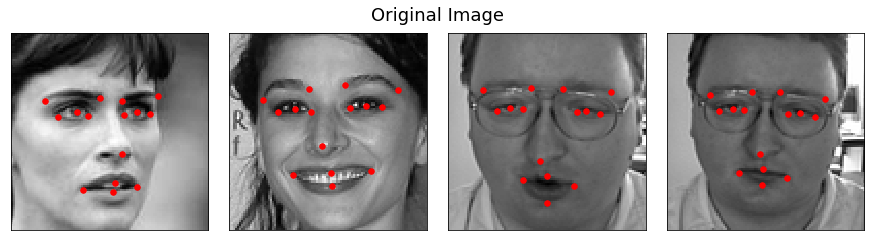

In [14]:
# Plotting original Samples
plot_sample(train_X[0:4], train_y[0:4])
plt.suptitle('Original Image', fontsize=18)
plt.show()

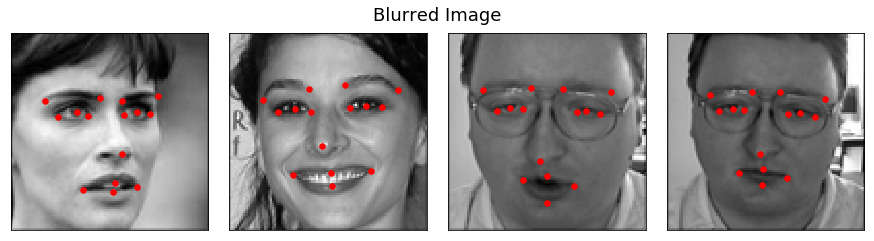

In [15]:
# Plotting Blurred images
# Blur first
blur_img = Blur_image(train_X[0:4])

# Plot samples
plot_sample(blur_img, train_y[0:4])
plt.suptitle('Blurred Image', fontsize=18)
plt.show()

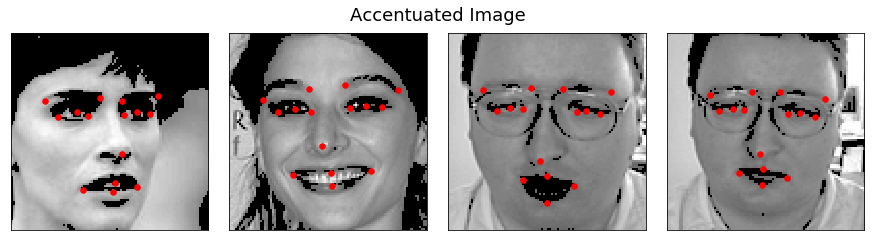

In [16]:
# Plotting Accentuated Images
# Accentuate images first
acc_img = accentuate_image(train_X[0:4])

# Plot Samples
plot_sample(acc_img[0:4], train_y[0:4])
plt.suptitle('Accentuated Image', fontsize=18)
plt.show()

## c) Flipping images and labels for extra training data

We note that if we only rely on images with 'complete' labels, we are not making use of most of the data  - there are only 1842 images in our training set that have all of the labels marked. In order to increase our training data, we will use a form of bootstrapping - we can double the amount of 'complete' training data (or really any part of our data) by using a reverse index on the image array data to flip the image. We can then apply a transformation on the x-coordinates of the feature labels to ensure that our flipped label coordinates match the flipped image data (note that the y-coordinates do not need to be adjusted).

In [0]:
# create a function to flip images and labels

def flip_image(img_array, img_labels):
  flipped_images = np.empty(img_array.shape)
  for i in range(len(img_array)):
    img_array1 = img_array.copy()
    
    # reshape the array to 96x96 shape, flip the row values, 
    # then reshape back to the original 1x9216 shape
    arr = img_array1[i].reshape(96,96)[:,::-1].reshape(1, 9216)
    
    # add the flipped array to flipped images
    flipped_images[i] = arr
  
  flipped_labels = np.empty(img_labels.shape)
  
  # Flip the labels
  for i in range(len(img_labels)):
    img_labels1 = img_labels.copy()
    
    # reshape the label array to a 15x2 array
    # 0th column will be the x-coordinates of the labels
    # multiply the x-coordinates by -1 to flip them horizontally
    label = img_labels1[i].reshape(15,2)
    label[:,0] *= -1
    label = label.reshape(15,2)
    
    # reshape back to the original shape
    label = label.reshape(1, 30)
    
    # We need also to flip right eye label to left eye label, otherwise the model accuracy will decrease
    flip_indices = {0:2, 2:0, 1:3, 3:1, 4:8, 8:4, 5:9, 9:5, 6:10, 10:6, 
                    7:11, 11:7, 12:16, 16:12, 13: 17, 17:13, 14:18, 18:14, 
                    15:19, 19:15, 22:24, 24:22, 23:25, 25:23, 20:20, 
                    21:21, 26:26, 27:27, 28:28, 29:29}
    label1 = np.empty(label.shape)
    for j in range(30):
      label1[:,j] = label[:,flip_indices[j]]
    
    # add the flipped label to flipped labels array
    flipped_labels[i] = label1  
    
  return flipped_images, flipped_labels
    

In [0]:
# flip our 'complete' dataset
train_X_flipped, train_y_flipped = flip_image(train_X, train_y)

Next we can take a look at an example of our flipped training data

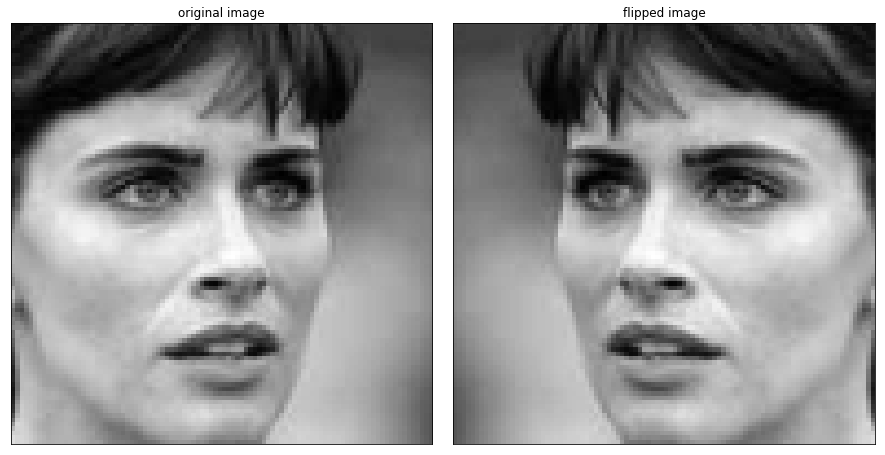

In [19]:
# Set figure information
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot original flipped images
axis = fig.add_subplot(2, 2, 1, xticks = [], yticks = [], title='original image')
axis.imshow(train_X[0].reshape(96,96),cmap='gray')
axis = fig.add_subplot(2, 2, 2, xticks = [], yticks = [], title='flipped image')
axis.imshow(train_X_flipped[0].reshape(96,96), cmap='gray') 
plt.show()

And see that the labels, too, are correctly flipped

left_eye_center_x left_eye_center_y


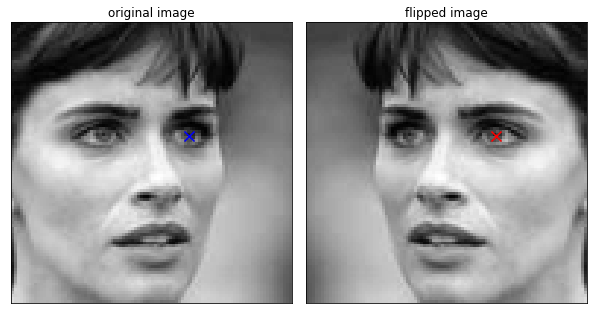

right_eye_center_x right_eye_center_y


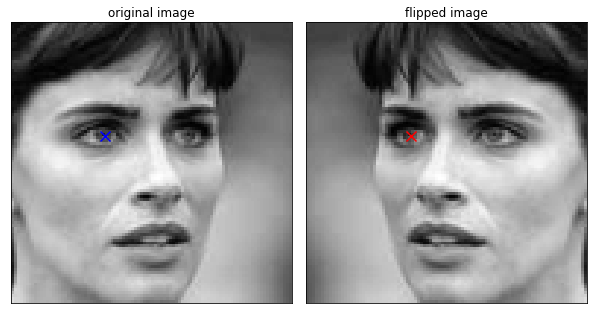

left_eyebrow_inner_end_x left_eyebrow_inner_end_y


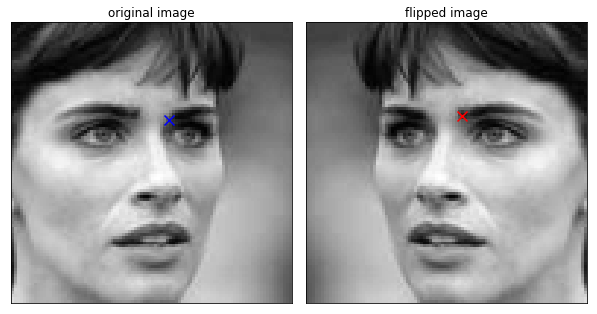

right_eyebrow_outer_end_x right_eyebrow_outer_end_y


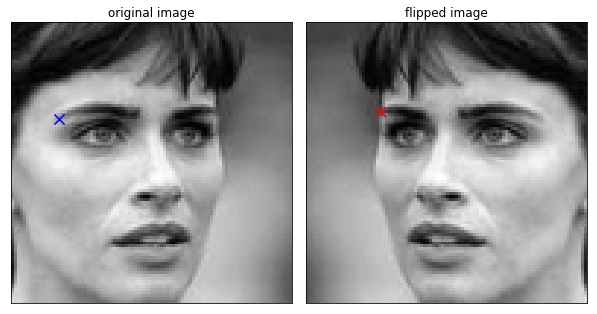

mouth_left_corner_x mouth_left_corner_y


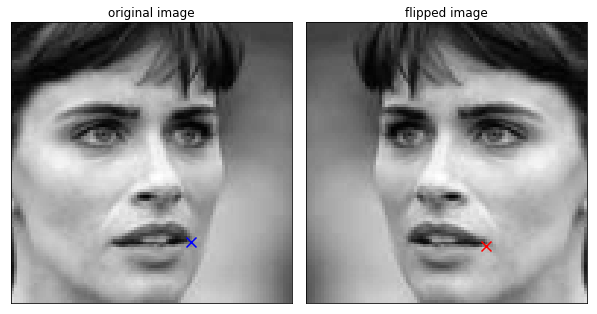

mouth_right_corner_x mouth_right_corner_y


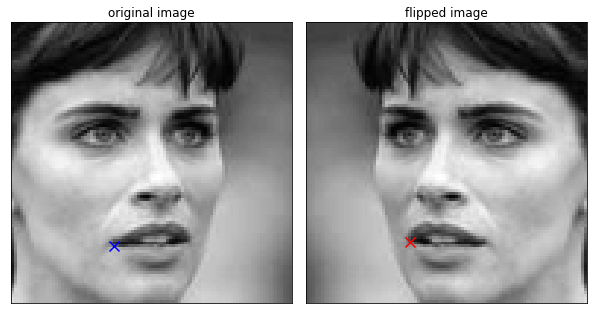

mouth_center_top_lip_x mouth_center_top_lip_y


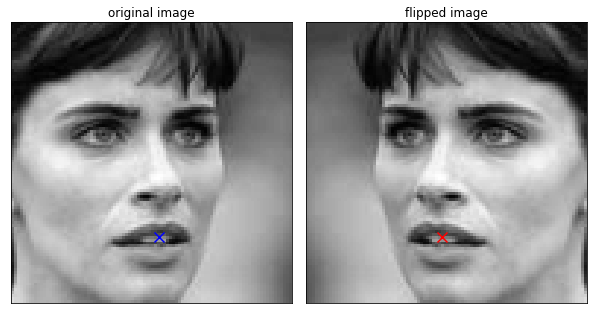

In [20]:
# Select labels to display
example_label_combos = [(0,1), (2,3), (12,13),(18,19), 
                        (22,23), (24,25), (26,27)]

# For each label, plot to show labels are flipped correctly
for item in example_label_combos:
  # Print label description
  print(train_labels[item[0]], train_labels[item[1]])

  keypoints_1_flipped = train_y_flipped[0,:]
  keypoints_2_flipped = keypoints_1_flipped*48 + 48

  keypoints_1_orig = train_y[0,:]
  keypoints_2_orig = keypoints_1_orig*48 + 48

  # Plot
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(
  left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

  axis = fig.add_subplot(2, 2, 2, xticks = [], yticks = [], title='flipped image')
  axis.imshow(train_X_flipped[0].reshape(96,96),cmap='gray')
  axis.scatter(keypoints_2_flipped[item[0]],
               keypoints_2_flipped[item[1]],
               c='r',marker="x", s=100)


  axis = fig.add_subplot(2, 2, 1, xticks = [], yticks = [],  title='original image')
  axis.imshow(train_X[0].reshape(96,96),cmap='gray')
  axis.scatter(keypoints_2_orig[item[0]],
               keypoints_2_orig[item[1]],
               c='b',marker="x", s=100)
  plt.show()

In [0]:
# Add the flipped images to our training data
more_data = np.append(train_X, train_X_flipped, axis=0)

more_labels = np.append(train_y, train_y_flipped, axis=0)

np.random.shuffle(more_data) 
np.random.shuffle(more_labels)

In [35]:
print(more_data.shape)
print(more_labels.shape)

(3684, 9216)
(3684, 30)


Now that we have some functions to engineer  the features in our training data, we can get a baseline accuracy measure for our predictions using KNN and Linear Regression classification models. With that baseline, we can then evaluate the magnitude of the expected increase in performance of the Neural Net model

# IV. KNN Classification and Scoring

The first of the baseline models to compare against the Neural Net model in prediction accuracy for facial keypoints is the K-Nearest Neighbors model. KNN uses "feature similarity" to predict values of new data points. 


*   Model: K -Nearest Neighbors
*   Cost and Objective: KNN has no explicit cost or objective functions as it is non-parametric, lazy learner model
*   k (number of nearest neighbours) and distance are hyperparameters. 
*   The distance function used in this model will be the Euclidean ($l$2) Distance (which is the sklearn default) and will not be optimized for as we are only interested in a baseline value for RMSE against the dev data using kNN
*   Hyperparameter k chosen by comparing regression coefficient R^2 for predictions against subsets of the training data (using a folding algorithm)
*   Dev Data Scoring: RMSE (Root Mean Square Error)

A note on using RMSE for scoring: This method is chosen for evaluation because the kaggle competition uses it to score the models that are submitted. This method punishes large errors. The better a model does in prediction, the LOWER the RMSE will be.

### a) Original Training Data

In [24]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, make_scorer

import warnings
warnings.filterwarnings("ignore")

# We will use the KNN Regressor algorithm in sklearn that calculates the 
# average of the numerical target of the K-nearest Neighbors .
# each label output is a regression value as opposed to a classifier

# find optimal k using GridSearchCV - which uses a folding technique to internally
# generate train and dev data

param = {'n_neighbors': [2,3,4,5,6,7,8,9]}
knn_regressor = KNeighborsRegressor()
score_method = make_scorer(r2_score)
knn_search = GridSearchCV(knn_regressor, param, cv=5, scoring=score_method)
knn_search.fit(train_X, train_y)
best_k = knn_search.best_params_  
optimal_k = knn_search.best_params_['n_neighbors']

print("optimal k: ", optimal_k)

optimal k:  5


In [25]:
# Now run predictions on dev set using the optimal k from above
knn=KNeighborsRegressor(n_neighbors = optimal_k)
knn.fit(train_X, train_y)
dev_predict_label= knn.predict(dev_X)

print("RMSE of dev data: %.5f" % np.sqrt(mean_squared_error(dev_y, dev_predict_label)))

RMSE of dev data: 0.05225


RMSE for each label
left_eye_center_x : 0.037402477
left_eye_center_y : 0.03682094
right_eye_center_x : 0.038087893
right_eye_center_y : 0.036924597
left_eye_inner_corner_x : 0.03284698
left_eye_inner_corner_y : 0.03126577
left_eye_outer_corner_x : 0.047469396
left_eye_outer_corner_y : 0.043023597
right_eye_inner_corner_x : 0.033167753
right_eye_inner_corner_y : 0.03192633
right_eye_outer_corner_x : 0.046417978
right_eye_outer_corner_y : 0.045209505
left_eyebrow_inner_end_x : 0.04269119
left_eyebrow_inner_end_y : 0.04630125
left_eyebrow_outer_end_x : 0.0564499
left_eyebrow_outer_end_y : 0.06686415
right_eyebrow_inner_end_x : 0.044078678
right_eyebrow_inner_end_y : 0.04585312
right_eyebrow_outer_end_x : 0.058940772
right_eyebrow_outer_end_y : 0.06053864
nose_tip_x : 0.0548207
nose_tip_y : 0.062403783
mouth_left_corner_x : 0.062388793
mouth_left_corner_y : 0.07176053
mouth_right_corner_x : 0.059195966
mouth_right_corner_y : 0.06965258
mouth_center_top_lip_x : 0.049800605
mouth_center_top

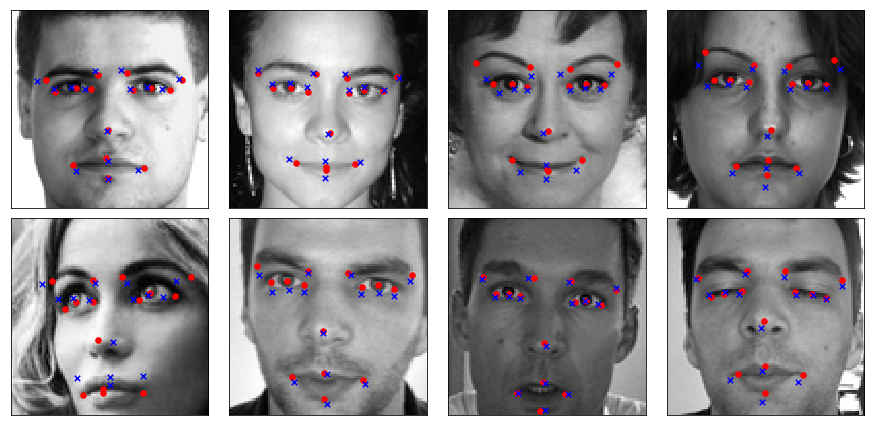

In [27]:
# List out all of the label names and performance on an individual basis on the dev data
label_names = list(pd.DataFrame(pd.read_csv(filepath + 'training.csv')).columns)[:-1]

#how each individual label performed 
RMSE = np.sqrt(metrics.mean_squared_error(dev_y, dev_predict_label, multioutput='raw_values'))

print('RMSE for each label')

for i in range(len(RMSE)):
  print(label_names[i], ':', RMSE[i])
  
print("\nSamples showing actual labels in red and predicted values in blue")
  
plot_sample(dev_X[0:8], dev_y[0:8], dev_predict_label[0:8])   


### b) Use accentuated images  

Note that we are not re-fitting k, only using the optimum k found above using the original training data

RMSE of dev data on accentuated images: 0.05141
RMSE for each label of accentuated images
left_eye_center_x : 0.036632355
left_eye_center_y : 0.035432734
right_eye_center_x : 0.03660742
right_eye_center_y : 0.03656308
left_eye_inner_corner_x : 0.032408845
left_eye_inner_corner_y : 0.030427523
left_eye_outer_corner_x : 0.0459311
left_eye_outer_corner_y : 0.04213678
right_eye_inner_corner_x : 0.032072067
right_eye_inner_corner_y : 0.031527642
right_eye_outer_corner_x : 0.045268722
right_eye_outer_corner_y : 0.045365233
left_eyebrow_inner_end_x : 0.04206591
left_eyebrow_inner_end_y : 0.045657087
left_eyebrow_outer_end_x : 0.055761233
left_eyebrow_outer_end_y : 0.065163694
right_eyebrow_inner_end_x : 0.042539485
right_eyebrow_inner_end_y : 0.046598285
right_eyebrow_outer_end_x : 0.055764087
right_eyebrow_outer_end_y : 0.058806
nose_tip_x : 0.05321717
nose_tip_y : 0.06290043
mouth_left_corner_x : 0.06167454
mouth_left_corner_y : 0.06862374
mouth_right_corner_x : 0.06409679
mouth_right_corne

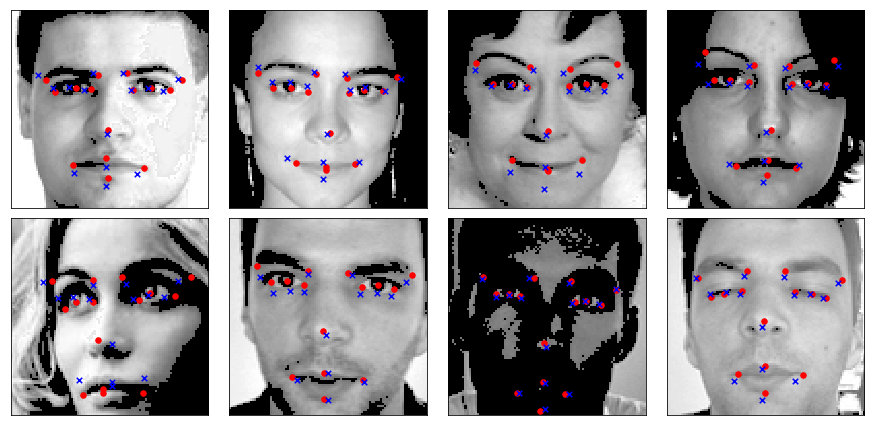

In [28]:
knn=KNeighborsRegressor(n_neighbors = optimal_k)

# fit the KNN model
preprocessed_train = accentuate_image(train_X)
knn.fit(preprocessed_train, train_y)

#and predict the labels
preprocessed_dev = accentuate_image(dev_X)
dev_predict_label= knn.predict(preprocessed_dev)

#Total RMSE of dev data
print("RMSE of dev data on accentuated images: %.5f" % np.sqrt(mean_squared_error(dev_y, dev_predict_label)))

# Display the Root Mean Squared Error for each label
RMSE = np.sqrt(metrics.mean_squared_error(dev_y, dev_predict_label, multioutput = 'raw_values'))

print('RMSE for each label of accentuated images')
for i in range(len(RMSE)):
  print(label_names[i], ':', RMSE[i])
  
plot_sample(preprocessed_dev[0:8], dev_y[0:8], dev_predict_label[0:8])

### c) Use blurred images

RMSE of dev data using blurred images: 0.05234

RMSE for each label in blurred images
left_eye_center_x : 0.037396014
left_eye_center_y : 0.036286037
right_eye_center_x : 0.037751228
right_eye_center_y : 0.037305962
left_eye_inner_corner_x : 0.032841444
left_eye_inner_corner_y : 0.031044139
left_eye_outer_corner_x : 0.047189236
left_eye_outer_corner_y : 0.042592708
right_eye_inner_corner_x : 0.033179224
right_eye_inner_corner_y : 0.032272566
right_eye_outer_corner_x : 0.04590756
right_eye_outer_corner_y : 0.04560202
left_eyebrow_inner_end_x : 0.042445753
left_eyebrow_inner_end_y : 0.046278007
left_eyebrow_outer_end_x : 0.056292534
left_eyebrow_outer_end_y : 0.06613294
right_eyebrow_inner_end_x : 0.04364153
right_eyebrow_inner_end_y : 0.046098474
right_eyebrow_outer_end_x : 0.058548424
right_eyebrow_outer_end_y : 0.06028076
nose_tip_x : 0.0550975
nose_tip_y : 0.062465996
mouth_left_corner_x : 0.061104197
mouth_left_corner_y : 0.07293831
mouth_right_corner_x : 0.059029695
mouth_right_cor

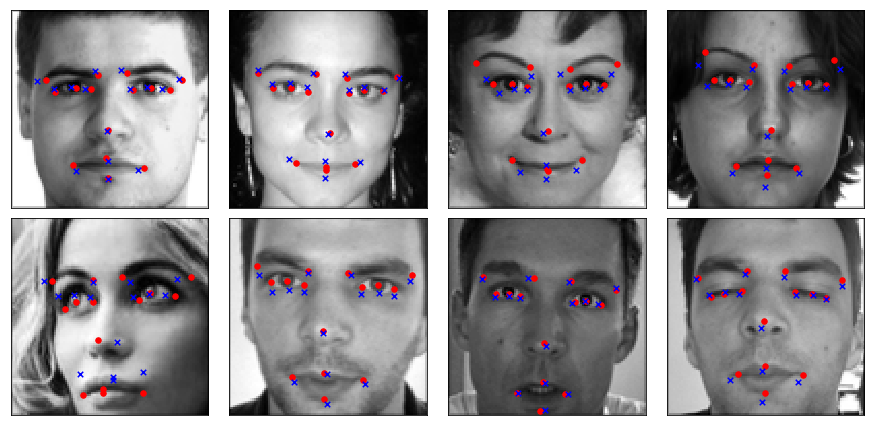

In [29]:
knn=KNeighborsRegressor(n_neighbors = optimal_k)

# fit the KNN model
preprocessed_train = Blur_image(train_X)
knn.fit(preprocessed_train, train_y)

#and predict the labels
preprocessed_dev = Blur_image(dev_X)
dev_predict_label= knn.predict(preprocessed_dev)

#Total RMSE of dev data
print("RMSE of dev data using blurred images: %.5f" % np.sqrt(mean_squared_error(dev_y, dev_predict_label)))

# Display the Root Mean Squared Error for each label
RMSE = np.sqrt(metrics.mean_squared_error(dev_y, dev_predict_label, multioutput = 'raw_values'))

print('\nRMSE for each label in blurred images')
for i in range(len(RMSE)):
  print(label_names[i], ':', RMSE[i])
  
plot_sample(preprocessed_dev[0:8], dev_y[0:8], dev_predict_label[0:8])

### d) Use larger data set with flipped images  
This will create a doubled data set that is fully labelled (similar to bootstrapping)

In [0]:
# Combine original image with flipped image
more_data1 = np.append(train_X, train_X_flipped, axis=0)


more_labels1 = np.append(train_y, train_y_flipped, axis=0)


# shuffle the combined train data
s=np.arange(more_data1.shape[0])
np.random.shuffle(s)

more_data = more_data1[s]
more_labels = more_labels1[s]

In [38]:
knn=KNeighborsRegressor(n_neighbors = optimal_k)

# fit the KNN model
knn.fit(more_data, more_labels)

#and predict the labels
dev_predict_label= knn.predict(dev_X)

#Total RMSE of dev data
print("RMSE of dev data using larger training set: %.5f" % np.sqrt(mean_squared_error(dev_y, dev_predict_label)))

# Display the Root Mean Squared Error for each label
RMSE = np.sqrt(metrics.mean_squared_error(dev_y, dev_predict_label, multioutput = 'raw_values'))

print('\nRMSE for each label')
for i in range(len(RMSE)):
  print(label_names[i], ':', RMSE[i])

RMSE of dev data using larger training set: 0.05201

RMSE for each label
left_eye_center_x : 0.036791519560181375
left_eye_center_y : 0.03777189998835135
right_eye_center_x : 0.03776858433958992
right_eye_center_y : 0.03761437559560917
left_eye_inner_corner_x : 0.031786720891539375
left_eye_inner_corner_y : 0.03141364687580275
left_eye_outer_corner_x : 0.04514347340554509
left_eye_outer_corner_y : 0.04344737976007364
right_eye_inner_corner_x : 0.032887041691255794
right_eye_inner_corner_y : 0.03289110454171217
right_eye_outer_corner_x : 0.045568409718155664
right_eye_outer_corner_y : 0.04481105112913172
left_eyebrow_inner_end_x : 0.04097376590992547
left_eyebrow_inner_end_y : 0.04632465092348639
left_eyebrow_outer_end_x : 0.05458175896285223
left_eyebrow_outer_end_y : 0.06670280028297616
right_eyebrow_inner_end_x : 0.04259482081970256
right_eyebrow_inner_end_y : 0.04685526549404313
right_eyebrow_outer_end_x : 0.05821176327436356
right_eyebrow_outer_end_y : 0.05927622824248807
nose_tip_

The K-Nearest Neighbors Model shows strong performance with a 0.05 RMSE, which might be sufficient in some circumstances. For proper identification, however, it likely is not good enough, especially noting that the RMSE for each label varies greatly. 

Additionally, it does not seem like the features engineering methods attempted significantly improved the performance at all.

# V. Linear Regression Classification & Scoring

To get another baseline for how well the Neural Net model performs, here we fit and train a Linear Regression model to predict the facial keypoint locations for our DEV data set. This model assumes a linear relationship between the dependent variables (x/y coordinates for facial keypoints) and the independent variables (the 9216 features in each image data vector) when mapping the best-fit hyper-plane to estimate the coordinates of the facial keypoints.

In order to find the best-fit hyperplane (i.e. find the best parameters for our model), the cost function is is the Mean Square Error, when using the LR algorithm in sklearn. The objective is to  find the parameters such that the uniform average MSE is minimzed. To do that we will use Gradient Descent.

To ensure comparison between this model and the kNN and Neural Net models, given that the facial keypoint coordinates that we are trying to predict are continuous values, we will use the Root Mean Squared Error (RMSE) to gauge how well the model predicts the labeled values in the DEV data. Squaring the difference between $\hat{y}$ and $y$ will penalize predicted values that are far from the actual coordinate values. It is unfortunate that essentially the same metric is used for evaluating the model (RMSE) and optimizing for the parameters in the model (MSE), but this is a feature of the linear regression model and the gradient descent method.

In summary:
* Model: Linear Regression
* Cost Function: Mean Squared Error (MSE)
* Objective: Minimize the unifrom average MSE
* Methodology: Gradient Descent
* Scoring: use RMSE to score performance on the Dev data using optimal parameters determined in the fit 

### a) Original Training Data

RMSE uniform average for the model: 0.05693019

RMSE for each label
left_eye_center_x : 0.041283246
left_eye_center_y : 0.035981543
right_eye_center_x : 0.04164554
right_eye_center_y : 0.03592273
left_eye_inner_corner_x : 0.039211925
left_eye_inner_corner_y : 0.033111088
left_eye_outer_corner_x : 0.049773213
left_eye_outer_corner_y : 0.04115612
right_eye_inner_corner_x : 0.04079971
right_eye_inner_corner_y : 0.03604317
right_eye_outer_corner_x : 0.05583152
right_eye_outer_corner_y : 0.041999083
left_eyebrow_inner_end_x : 0.053948753
left_eyebrow_inner_end_y : 0.053150058
left_eyebrow_outer_end_x : 0.0629526
left_eyebrow_outer_end_y : 0.068907544
right_eyebrow_inner_end_x : 0.04808287
right_eyebrow_inner_end_y : 0.05612929
right_eyebrow_outer_end_x : 0.06679716
right_eyebrow_outer_end_y : 0.06986443
nose_tip_x : 0.053566284
nose_tip_y : 0.07533058
mouth_left_corner_x : 0.07058037
mouth_left_corner_y : 0.073617145
mouth_right_corner_x : 0.06254947
mouth_right_corner_y : 0.072772324
mouth

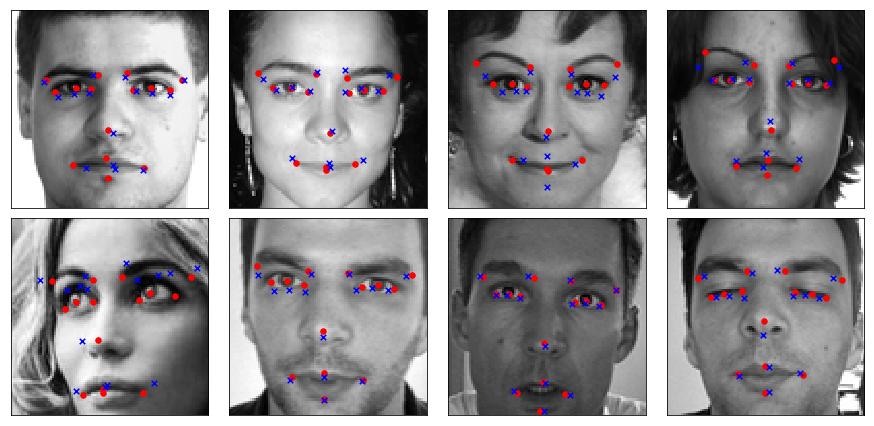

In [32]:
# Instantiate a LR model with the LogisticRegression class

# Set the multi_class parameter to 'multinomial' as our outputs are not
# binomial, hence one-vs-rest will not work as well

# In order to use multinomial option, we need a non "liblinear" solver
# Available solvers for multinomial: ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ 

lr_mod = LinearRegression()

# List out all of the label names
label_names = list(train_labels)

# fit the Linear Regression model to the un-modified data
lr_mod.fit(train_X, train_y)

# Predict the labels on the dev set
lr_pred = lr_mod.predict(dev_X)

# Display the Root Mean Squared Error for each label
RMSE = np.sqrt(metrics.mean_squared_error(dev_y, 
                                          lr_pred, 
                                          multioutput = 'raw_values'))

print('RMSE uniform average for the model:',
     np.sqrt(metrics.mean_squared_error(dev_y, 
                                        lr_pred, 
                                        multioutput = 'uniform_average')))

print('\nRMSE for each label')
for i in range(len(RMSE)):
  print(label_names[i], ':', RMSE[i])
  

plot_sample(dev_X[0:8], dev_y[0:8], lr_pred[0:8])

### b) Use accentuated images

In [34]:
lr_mod = LinearRegression()

# fit the Linear Regression model
preprocessed_train = Blur_data(train_X)
lr_mod.fit(preprocessed_train, train_y)

# and predict the labels
preprocessed_dev = Blur_data(dev_X)
lr_pred = lr_mod.predict(preprocessed_dev)

# Display the Root Mean Squared Error for each label
RMSE = np.sqrt(metrics.mean_squared_error(dev_y, 
                                          lr_pred, 
                                          multioutput = 'raw_values'))

print('RMSE uniform average for the model with blurred images:',
     np.sqrt(metrics.mean_squared_error(dev_y, 
                                        lr_pred, 
                                        multioutput = 'uniform_average')))
  
print('\nRMSE for each label with blurred images')
for i in range(len(RMSE)):
  print(label_names[i], ':', RMSE[i])
  
plot_sample(preprocessed_dev[0:8], dev_y[0:8], lr_pred[0:8])

NameError: ignored

### c) Use blurred images

RMSE uniform average for the model with blurred images: 0.058703780807066404

RMSE for each label with blurred images
left_eye_center_x : 0.04239920669761482
left_eye_center_y : 0.03731143341942384
right_eye_center_x : 0.04264649879289388
right_eye_center_y : 0.03705450188008767
left_eye_inner_corner_x : 0.04049906110264902
left_eye_inner_corner_y : 0.034175876758954706
left_eye_outer_corner_x : 0.0513378334406359
left_eye_outer_corner_y : 0.04248634906287378
right_eye_inner_corner_x : 0.04199017815632501
right_eye_inner_corner_y : 0.037332164500591215
right_eye_outer_corner_x : 0.05734508396996456
right_eye_outer_corner_y : 0.043516887250860524
left_eyebrow_inner_end_x : 0.0556705810107674
left_eyebrow_inner_end_y : 0.05510200639653987
left_eyebrow_outer_end_x : 0.06463914262689906
left_eyebrow_outer_end_y : 0.07083121522652294
right_eyebrow_inner_end_x : 0.04986257561913425
right_eyebrow_inner_end_y : 0.0576233949124121
right_eyebrow_outer_end_x : 0.06874151572502098
right_eyebrow_ou

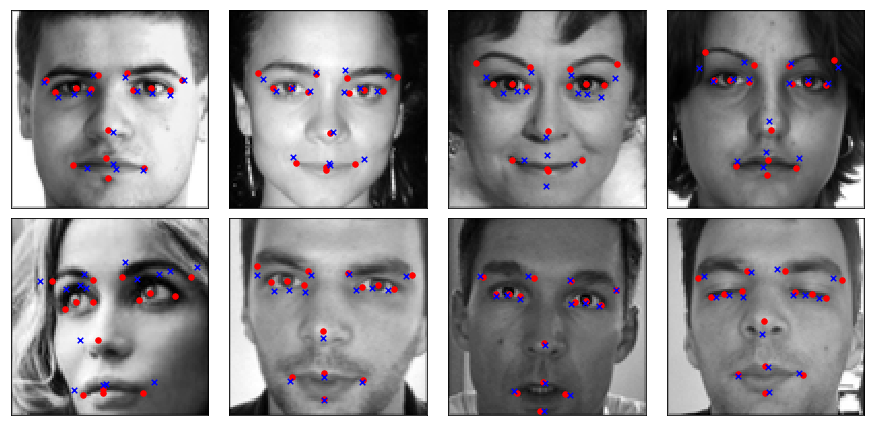

In [37]:
lr_mod = LinearRegression()

# fit the Linear Regression model
preprocessed_train = Blur_image(train_X)
lr_mod.fit(preprocessed_train, train_y)

# and predict the labels
preprocessed_dev = Blur_image(dev_X)
lr_pred = lr_mod.predict(preprocessed_dev)

# Display the Root Mean Squared Error for each label
RMSE = np.sqrt(metrics.mean_squared_error(dev_y, 
                                          lr_pred, 
                                          multioutput = 'raw_values'))

print('RMSE uniform average for the model with blurred images:',
     np.sqrt(metrics.mean_squared_error(dev_y, 
                                        lr_pred, 
                                        multioutput = 'uniform_average')))
  
print('\nRMSE for each label with blurred images')
for i in range(len(RMSE)):
  print(label_names[i], ':', RMSE[i])
  
plot_sample(preprocessed_dev[0:8], dev_y[0:8], lr_pred[0:8])

### d) Use larger data set with flipped images

RMSE for each label
left_eye_center_x : 0.07734272671712329
left_eye_center_y : 0.10170432263028267
right_eye_center_x : 0.08412636069426548
right_eye_center_y : 0.09422298439401768
left_eye_inner_corner_x : 0.07765997511552412
left_eye_inner_corner_y : 0.08958985137558062
left_eye_outer_corner_x : 0.10796296950867462
left_eye_outer_corner_y : 0.12027248852680573
right_eye_inner_corner_x : 0.08043008886187192
right_eye_inner_corner_y : 0.0831276699836139
right_eye_outer_corner_x : 0.11296458228489209
right_eye_outer_corner_y : 0.11308796447976864
left_eyebrow_inner_end_x : 0.11088166032468373
left_eyebrow_inner_end_y : 0.12211094745837223
left_eyebrow_outer_end_x : 0.13739108331775035
left_eyebrow_outer_end_y : 0.1657312163878256
right_eyebrow_inner_end_x : 0.11307659627770139
right_eyebrow_inner_end_y : 0.11817464258034914
right_eyebrow_outer_end_x : 0.13566014091305517
right_eyebrow_outer_end_y : 0.15512964159628959
nose_tip_x : 0.1344864717452723
nose_tip_y : 0.17698651047117003
mou

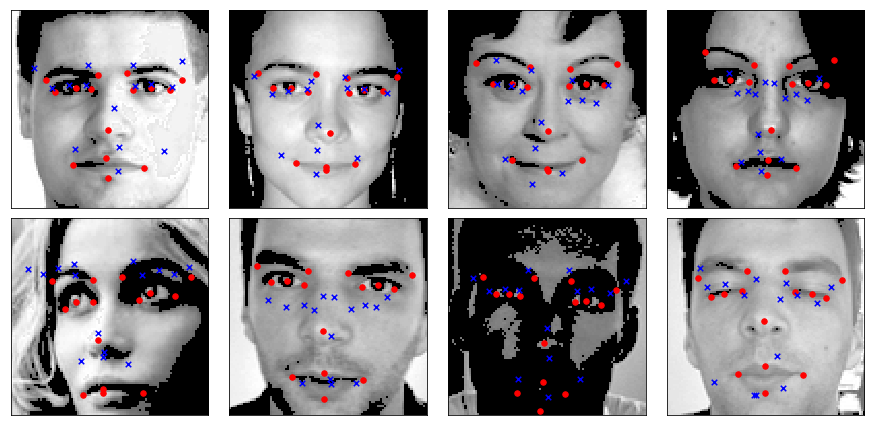

In [0]:
# with MORE DATA

lr_mod = LinearRegression()
lr_mod.fit(more_data, more_labels)

# and predict the labels
lr_pred = lr_mod.predict(dev_X)

# Display the Root Mean Squared Error for each label
RMSE = np.sqrt(metrics.mean_squared_error(dev_y, 
                                          lr_pred, 
                                          multioutput = 'raw_values'))

print('RMSE uniform average for the model:',
     np.sqrt(metrics.mean_squared_error(dev_y, 
                                        lr_pred, 
                                        multioutput = 'uniform_average')))

print('RMSE for each label')
for i in range(len(RMSE)):
  print(label_names[i], ':', RMSE[i])
  
plot_sample(accentuate_image(dev_X[0:8]), dev_y[0:8], lr_pred[0:8])

### e) Add labels to incomplete training data

In [39]:
incomplete_train_X, incomplete_train_y, incomplete_train_labels = load_data(data_type = 'train', data = 'incomplete')
#train_X, train_y, train_labels = load_data(data_type = 'train', data='complete')

Number of rows total after dropping completely labeled data = 4158


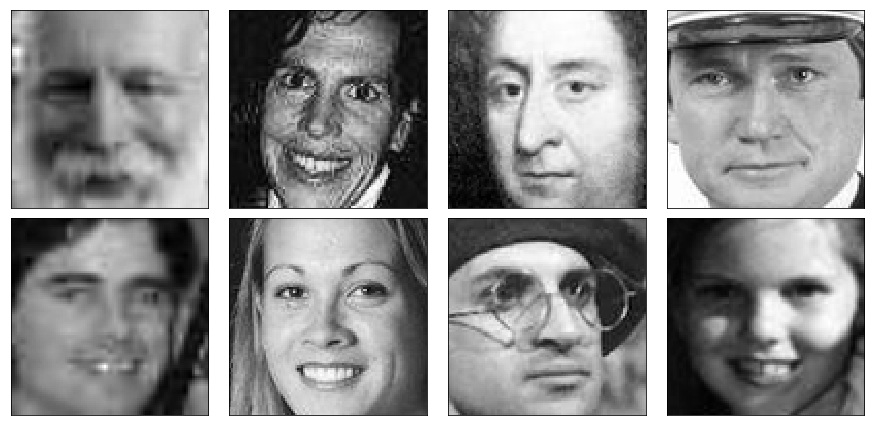

In [0]:
plot_sample(incomplete_train_X[0:8], incomplete_train_y[0:8])

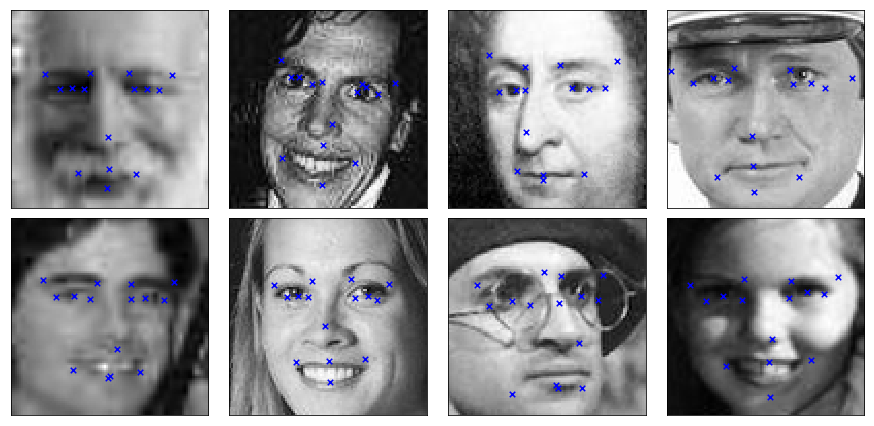

In [0]:
lr_mod = LinearRegression()

lr_mod.fit(train_X, train_y)
# and predict the labels
lr_pred = lr_mod.predict(incomplete_train_X)

# No need for RMSE since these images have missing/incomplete/no labels


plot_sample(incomplete_train_X[0:8], np.nan, lr_pred[0:8])

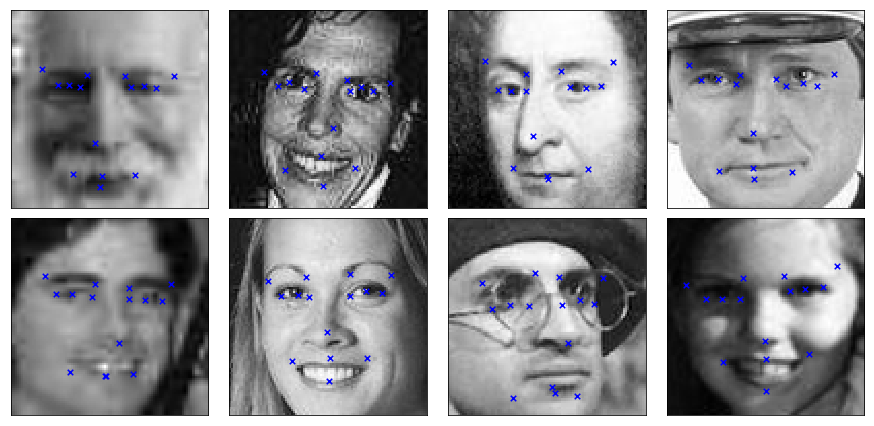

In [0]:
lr_mod = LinearRegression()

lr_mod.fit(accentuate_image(train_X), train_y)
# and predict the labels
lr_pred = lr_mod.predict(accentuate_image(incomplete_train_X))

# No need for RMSE since these images have missing/incomplete/no labels


plot_sample(incomplete_train_X[0:8], np.nan, lr_pred[0:8])

# 4. Setup

**QUESTIONS / Comments - Laura (July 12/13)**

_Per Class Discussions - breakdown the problem:_

* In this problem set: Given $X$ - a 96x96 pixel image of a face (a 1 x 9216 vector of pixel values); predict $\hat Y$ - the x and y coordinates of 15 specific facial keypoints (list above), or alternately fill in the values for missing keypoints where some are given in a test case.

* Data given is the labeled (or semi-labeled) images ($X$). This is a supervised learning problem. The labels ($Y$) are continuous values (x,y coordinate pairs - in essence a 15 x 2 array of x,y values for 15 facial keypoints)

* Features are the values of the pixels in the image and their relationship to each other (format of the relationship TBD)  
  - Commentary on feature engineering - some more research here
  - Features (pixels) will be reduced to values between 0 and 1 (vs original 256 grayscale)
  - for all models the features will be in a 1 x 9216 except for Convolutional NN which needs them reshaped to a 96x96 matrix
  - May want to apply a blur to the images - as per our digit exercise - in order to assist in recognition
  - We have a Curse of Dimensionality - very high dimension feature space (9216) and a relatively small number of examples and only 15 features to train on (~2140 complete examples, up to 6000 if we include those only partially labeled). This data is extremely sparse which may mean that multiple hidden layers are better in the Neural net and likely means that other models will fare poorly.
  

* Model to use: we will try various models - from simiplistic kNN, NaiveBayes and Logistic Regression to compare and to learn about the data. We will move on to Neural Net with various numbers of hidden layers (2? 3? more?). Eventually we will need a convolutional neural net.
  - Sigmoid or softmax or other activation? How to decide?
  - What *is* a convolutional neural net (cNN): *'The role of the cNN is to reduce the images into a form which is easier to process, without losing features which are critical for getting a good prediction'*
  - Why would a cNN be the best model
  - Why use RMSE to evaluate model
  - What tolerance will the x,y coordinates have to meet to say that they are predicting correctly? (i.e. to what decimal place?)
  - Type of pooling to use in pooling layers of CNN - likely max pooling is better (reduces noise)
  - then likely add a fully connected layer after the convolational layers to introduce non-linearities
  
* Issues that may be encountered:  
  - Dealing with data that is missing - see point 2 below - and impact on the model
  - Images contain a large variation regarding centering and this may impact the behaviour of the model
  - As we are dealing with multiple labels, do we do it with an all-or-nothing approach (i.e. predict all 15 labels correctly, or zero), or can we do a 'sliding-scale' of prediction - i.e. the more facial keypoints detected correctly, the higher the score?

  
* Assumptions:  
  - All faces are human and have detectable keypoints
  -  ? More
  
* References:
  - https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53 - an excellent description of what a CNN is.
  
  

_Questions_

1.   What are we predicting on - the kaggle competition indicates we should be predicting the missing x or y coordinate of the specified feature. Where is this file?? (submissionFileFormat.csv)?
2. This is a 'multi-label' problem - each example (image) has 15 'labels'. Not all examples have all labels. In the approach above, we have eliminated about half the training data. Once we get to the end, we should go back and revisit this and see if we can improve training by changing this:
  *   Train again only on the labels that span the whole training set (4 labels)
  *   Train using images that have missing features and incorporate that into the model (i.e. maybe there are patterns with the images that have missing features?)
  *   Reduce the label data using clustering (create new labels) and train again  - not sure how to un-transform the prediction tho
3. For the NN - using sigmoid activation may help us in the predictions
4. Do we need to shuffle the training data
5. In data processing ahead of training - lots to do here:
- Deal with images that aren't centered (will need examples. once we have those we can play around with transformation)




In [0]:
# Look at variability in training data using nose tip - element 10 (x is feature 20 and y is feature 21 in the train_y matrix- indexed from 0)
# define nose data:
nose = train_y[:,20:22]*48+48
plt.figure(figsize=(8,8))
plt.imshow(img,cmap='gray')
plt.scatter(nose[:,0],nose[:,1],edgecolors='r',marker="o",facecolors='none', s=30)
plt.show()

In [0]:
# Combine original image with flipped image
more_data1 = np.append(train_X, train_X_flipped, axis=0)


more_labels1 = np.append(train_y, train_y_flipped, axis=0)


# shuffle the combined train data
s=np.arange(more_data1.shape[0])
np.random.shuffle(s)

more_data = more_data1[s]
more_labels = more_labels1[s]


In [0]:

# Accentrated Image
Accentrated_train_X = accentuate_image(more_data) # accentrated flipped and original image belongs to train data
Accentrated_dev_X = accentuate_image(dev_X) # accentrated image for dev data

# Blur Image
Blur_train_X = Blur_image(more_data) # Blur flipped and original image belongs to train data
Blur_dev_X = Blur_image(dev_X) # Blur image for dev data

DO Some Stats on the labels - and look at relative functions of labels with each other - which are correlated, can can we use this to our advantage for the data where labels are missing?

- One approach is to ignore the error in a CNN on the final output layer per this paper: [https://shangyuezhu.github.io/shangyuezhu.github.io/images/Convolutional_Neural_Network.pdf]

- 

- 

In [0]:
# Code Laura Misc - this from https://medium.com/diving-in-deep/facial-keypoints-detection-with-pytorch-86bac79141e4
missing_any_data = np.isnan[more_data]
idxs = np.random.choice(missing_any_data.index, 4)
show_images(more_data, idxs)


# VI.Single Layer and Multi Layer Neural Network


In [0]:
def plot_example(x, y, axis, predicted_label=np.nan):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter((y.reshape(15,2) * 48 + 48)[:,0], (y.reshape(15,2) * 48 + 48)[:,1], marker='o', s=30, c='red')
    
    if np.all(np.isfinite(predicted_label)):
            plt.scatter((predicted_label.reshape(15,2) * 48 + 48)[:,0], (predicted_label.reshape(15,2) * 48 + 48)[:,1], c='blue', marker='x', label='predicted')

    return

In [0]:
def score(y,y_pred):
        return np.sqrt(mean_squared_error(y, y_pred))

## Part 1: Single Layer Neural Network (Perceptron)
### Following methodology is applied to improve performance of single layer neural network:


*   Learning rate: 0.01 and 0.001
*   Activation Function: linear regression and tanh function  (The sigmod and softmax doesn't work for this study, because the keypoint pairs range from -1 to 1, but the predicted labels only ranges from 0 to 1 with sigmod activation function)
*   Gradient Descent: batch, stochastic, and mini-batch 





### Part 1.1-1 Single Layer Neural Network with Tanh Activation Function (Try 1)


*   model: single layer neural network with tanh activation function
*   cost function: RMSE
*   Objective: minimize RMSE
*   Methodology: batch gradient descent
     * Learning Rate: 0.01



In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import tensorflow as tf


## (1) Parameters 
# Get number of features
num_features = train_X.shape[1]
# Then get the number of keypoints from labels
num_labels = train_y.shape[1]

# Initialize the weights to small, but non-zero, values.
# N(mu,sigma^2) --> sigma * np.random.randn() + mu
# each column is weight set for one output (y1), so total 30 columns for y1, y2...y30
w = theano.shared(np.asarray((np.random.randn(*(num_features, num_labels))*.01))) 

## (2) Model
# Theano objects accessed with standard Python variables
X = T.matrix()
Y = T.matrix()

# Softmax model is applied for multiple outputs logistic regression model
def model(X, w):
    #return T.nnet.softmax(T.dot(X, w))
    return T.tanh(T.dot(X, w))
    #return T.dot(X,w)
    #return T.nnet.rule(T.dot(X, w))

y_hat = model(X, w)

## (3) Cost function
cost = T.sqrt(T.mean((Y - y_hat)**2))

## (4) Objective (and solver)
alpha = 0.01 # Learning Rate
gradient = T.grad(cost=cost, wrt=w) 
update = [[w, w - gradient * alpha]] 
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True) # computes cost, then runs update
predict = theano.function(inputs=[X], outputs=y_hat, allow_input_downcast=True) # dtype np.float64 and your variable is instantiated to have dtype np.float32, the input is converted to np.float32 when the flag is set to True.

def gradientDescent(epochs):
    trainTime = 0.0
    predictTime = 0.0
    cost_vec = []
    cost_vec1 = []
    for i in range(epochs):
        start_time = time.time()
        cost = train(train_X[0:len(train_X)], train_y[0:len(train_X)])
        cost_vec.append(cost)
        trainTime =  trainTime + (time.time() - start_time)
        RMSE = np.sqrt(mean_squared_error(dev_y, predict(dev_X), multioutput='uniform_average'))
        cost_vec1.append(RMSE)
        print('RMSE', (i+1, RMSE))
        
    print('train time = ', trainTime)

    plt.plot(cost_vec, c='red', label='Train Data')
    plt.plot(cost_vec1, c='blue', label = 'Dev Data')
    plt.xlabel('Number of Gradient Descent steps')
    plt.ylabel('Cost function')
    plt.legend()
    plt.show()

gradientDescent(100)


The above Cost vs. Number of Epochs plot shows that the cost stop decreasing as it reaches 0.25 with 10 epochs. The way to further reduce the cost and improve model accuracy is to try different learning rate. 

####Part 1.1-2 Single Layer Neural Network with Tanh Activation Function (Try 2)
* model: single layer neural network with tanh activation function
* cost function: RMSE
* Objective: minimize RMSE
* Methodology: batch gradient descent
   * Learning Rate: 0.001

In [0]:
## (1) Parameters 
# Get number of features
num_features = train_X.shape[1]
# Then get the number of keypoints from labels
num_labels = train_y.shape[1]

# Initialize the weights to small, but non-zero, values.
# N(mu,sigma^2) --> sigma * np.random.randn() + mu
# each column is weight set for one output (y1), so total 30 columns for y1, y2...y30
w1 = theano.shared(np.asarray((np.random.randn(*(num_features, num_labels))*.01))) 

## (2) Model
# Theano objects accessed with standard Python variables
X1 = T.matrix()
Y1 = T.matrix()

# Softmax model is applied for multiple outputs logistic regression model
def model1(X1, w1): 
    return T.tanh(T.dot(X1, w1))
    
    
y_hat1 = model1(X1, w1)

## (3) Cost function
cost1 = T.sqrt(T.mean((Y1 - y_hat1)**2))

## (4) Objective (and solver)
alpha1 = 0.001 # Learning Rate
gradient1 = T.grad(cost=cost1, wrt=w1) 
update1 = [[w1, w1 - gradient1 * alpha1]] 
train1 = theano.function(inputs=[X1, Y1], outputs=cost1, updates=update1, allow_input_downcast=True) # computes cost, then runs update
predict1 = theano.function(inputs=[X1], outputs=y_hat1, allow_input_downcast=True) # dtype np.float64 and your variable is instantiated to have dtype np.float32, the input is converted to np.float32 when the flag is set to True.

def gradientDescent(epochs):
    trainTime = 0.0
    predictTime = 0.0
    cost_vec = []
    cost_vec1 = []
    for i in range(epochs):
        start_time = time.time()
        cost1 = train1(train_X[0:len(train_X)], train_y[0:len(train_X)])
        cost_vec.append(cost1)
        trainTime =  trainTime + (time.time() - start_time)
        RMSE = np.sqrt(mean_squared_error(dev_y, predict1(dev_X), multioutput='uniform_average'))
        cost_vec1.append(RMSE)
        print('RMSE', (i+1, RMSE))
        
    print('train time = ', trainTime)
    
    plt.plot(cost_vec, c='red', label='Train Data')
    plt.plot(cost_vec1, c='blue', label = 'Dev Data')
    plt.xlabel('Number of Gradient Descent steps')
    plt.ylabel('Cost function')
    plt.legend()
    plt.show()

gradientDescent(100)


The above Cost vs. Number of Epochs plot shows that the cost is significantly reduced to 0.15 with smaller learning rate of 0.001. With smaller learning rate, the curve becomes more smooth and approaches local minimization step by step. With proper learning rate, next step is to study the activation funcation.

#### Part 1.2 Single Layer Neural Network with linear regression 
* model: single layer neural network with linear regression
* cost function: RMSE
* Objective: minimize RMSE
* Methodology: batch gradient descent
    * Learning Rate: 0.001

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import tensorflow as tf

## (1) Parameters 
# Get number of features
num_features = train_X.shape[1]
# Then get the number of keypoints from labels
num_labels = train_y.shape[1]

# Initialize the weights to small, but non-zero, values.
# N(mu,sigma^2) --> sigma * np.random.randn() + mu
# each column is weight set for one output (y1), so total 30 columns for y1, y2...y30
w2 = theano.shared(np.asarray((np.random.randn(*(num_features+1, num_labels))*.01))) 

## (2) Model
# Theano objects accessed with standard Python variables
X2 = T.matrix()
Y2 = T.matrix()

# Softmax model is applied for multiple outputs logistic regression model
def model2(X2, w2):
    return T.dot(X2, w2[1:,:])+w2[0,:]
    
y_hat2 = model2(X2, w2)

## (3) Cost function
cost2 = T.sqrt(T.mean((Y2 - y_hat2)**2))

## (4) Objective (and solver)
alpha2 = 0.001 # Learning Rate
gradient2 = T.grad(cost=cost2, wrt=w2) 
update2 = [[w2, w2 - gradient2 * alpha2]] 
train2 = theano.function(inputs=[X2, Y2], outputs=cost2, updates=update2, allow_input_downcast=True) # computes cost, then runs update
predict2 = theano.function(inputs=[X2], outputs=y_hat2, allow_input_downcast=True) # dtype np.float64 and your variable is instantiated to have dtype np.float32, the input is converted to np.float32 when the flag is set to True.

def gradientDescent(epochs):
    trainTime = 0.0
    predictTime = 0.0
    cost_vec = []
    cost_vec1 = []
    for i in range(epochs):
        start_time = time.time()
        cost2 = train2(train_X[0:len(train_X)], train_y[0:len(train_X)])
        cost_vec.append(cost2)
        trainTime =  trainTime + (time.time() - start_time)
        RMSE = np.sqrt(mean_squared_error(dev_y, predict2(dev_X), multioutput='uniform_average'))
        cost_vec1.append(RMSE)
        print('RMSE', (i+1, RMSE))
        # print('accuracy = ', (i+1, r2_score(dev_y, predict(dev_X)))) 
    print('train time = ', trainTime)
    
    plt.plot(cost_vec, c='red', label='Train Data')
    plt.plot(cost_vec1, c='blue', label = 'Dev Data')
    plt.xlabel('Number of Gradient Descent steps')
    plt.ylabel('Cost function')
    plt.legend()
    plt.show()
    
gradientDescent(100)


The above Cost vs. Number of Epochs plot shows that the performance of linear regression is comparable to that of tanh activation function. The RMSE is around 0.17 with 100 Epochs. 

#### Part 1.3 Single Layer Neural Network with tanh activation function and stochastic gradient descent
* model: single layer neural network with tanh activation function
* cost function: RMSE
* Objective: minimize RMSE
* Methodology: stochastic gradient descent
   * Learning Rate: 0.001

In [0]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import tensorflow as tf

## (1) Parameters 
# Get number of features
num_features = train_X.shape[1]
# Then get the number of keypoints from labels
num_labels = train_y.shape[1]

# Initialize the weights to small, but non-zero, values.
# N(mu,sigma^2) --> sigma * np.random.randn() + mu
# each column is weight set for one output (y1), so total 30 columns for y1, y2...y30
w3 = theano.shared(np.asarray((np.random.randn(*(num_features, num_labels))*.01))) 

## (2) Model
# Theano objects accessed with standard Python variables
X3 = T.matrix()
Y3 = T.matrix()

# Softmax model is applied for multiple outputs logistic regression model
def model3(X3, w3): 
    return T.tanh(T.dot(X3, w3))
    
    
y_hat3 = model3(X3, w3)

## (3) Cost function
cost3 = T.sqrt(T.mean((Y3 - y_hat3)**2))

## (4) Objective (and solver)
alpha3 = 0.001 # Learning Rate
gradient3 = T.grad(cost=cost3, wrt=w3) 
update3 = [[w3, w3 - gradient3 * alpha3]] 
train3 = theano.function(inputs=[X3, Y3], outputs=cost3, updates=update3, allow_input_downcast=True) # computes cost, then runs update
predict3 = theano.function(inputs=[X3], outputs=y_hat3, allow_input_downcast=True) # dtype np.float64 and your variable is instantiated to have dtype np.float32, the input is converted to np.float32 when the flag is set to True.



miniBatchSize = 1 
def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    cost_vec = []
    cost_vec1 = []
    start_time = time.time()
    for i in range(epochs):       
        for start, end in zip(range(0, len(train_X), miniBatchSize), range(miniBatchSize, len(train_X), miniBatchSize)):
            cost3 = train3(train_X[start:end], train_y[start:end])
        cost_vec.append(cost3)
        trainTime =  trainTime + (time.time() - start_time)
        RMSE = np.sqrt(mean_squared_error(dev_y, predict3(dev_X), multioutput='uniform_average'))
        cost_vec1.append(RMSE)
        print('RMSE', (i+1, RMSE))    
    print('train time = ', trainTime)
    
    plt.plot(cost_vec, c='red', label='Train Data')
    plt.plot(cost_vec1, c='blue', label = 'Dev Data')
    plt.xlabel('Number of Gradient Descent steps')
    plt.ylabel('Cost function')
    plt.legend()
    plt.show()
    
gradientDescentStochastic(100)


With stochastic gradient descent, the RMSE is further reduced. The RMSE for dev data is 0.096 with 100 Epochs. Because update are more frequet with stochasitc gradient descent. For each epoch, the weights are updated 1842 times. Due to this reason, the computation time is much longer. Because the data is updated more frequently, the cost  fluctuates significantly with each epochs. In order to shorten computation time and keep accuracy, the mini batch is applied for simulation below.

### Part 1.4 Single Layer Neural Network with tanh activation function and mini gradient descent
* model: single layer neural network with tanh activation function
* cost function: RMSE
* Objective: minimize RMSE
* Methodology: mini-batch gradient descent
   * Learning Rate: 0.001

In [0]:
## (1) Parameters 
# Get number of features
num_features = train_X.shape[1]
# Then get the number of keypoints from labels
num_labels = train_y.shape[1]

# Initialize the weights to small, but non-zero, values.
# N(mu,sigma^2) --> sigma * np.random.randn() + mu
# each column is weight set for one output (y1), so total 30 columns for y1, y2...y30
w4 = theano.shared(np.asarray((np.random.randn(*(num_features, num_labels))*.01))) 

## (2) Model
# Theano objects accessed with standard Python variables
X4 = T.matrix()
Y4 = T.matrix()

# Softmax model is applied for multiple outputs logistic regression model
def model4(X4, w4): 
    return T.tanh(T.dot(X4, w4))
    
    
y_hat4 = model4(X4, w4)

## (3) Cost function
cost4 = T.sqrt(T.mean((Y4 - y_hat4)**2))

## (4) Objective (and solver)
alpha4 = 0.001 # Learning Rate
gradient4 = T.grad(cost=cost4, wrt=w4) 
update4 = [[w4, w4 - gradient4 * alpha4]] 
train4 = theano.function(inputs=[X4, Y4], outputs=cost4, updates=update4, allow_input_downcast=True) # computes cost, then runs update
predict4 = theano.function(inputs=[X4], outputs=y_hat4, allow_input_downcast=True) # dtype np.float64 and your variable is instantiated to have dtype np.float32, the input is converted to np.float32 when the flag is set to True.



miniBatchSize = 10 
def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    cost_vec = []
    cost_vec1 = []
    start_time = time.time()
    for i in range(epochs):       
        for start, end in zip(range(0, len(train_X), miniBatchSize), range(miniBatchSize, len(train_X), miniBatchSize)):
            cost4 = train4(train_X[start:end], train_y[start:end])
        cost_vec.append(cost4)
        trainTime =  trainTime + (time.time() - start_time)
        RMSE=np.sqrt(mean_squared_error(dev_y, predict4(dev_X), multioutput='uniform_average'))
        cost_vec1.append(RMSE)
        print('RMSE', (i+1, RMSE))    
    print('train time = ', trainTime)
    
    plt.plot(cost_vec, c='red', label='Train Data')
    plt.plot(cost_vec1, c='blue', label = 'Dev Data')
    plt.xlabel('Number of Gradient Descent steps')
    plt.ylabel('Cost function')
    plt.legend()
    plt.show()
    
gradientDescentStochastic(100)





With mini-batch gradient descent, the RMSE is further reduced. The RMSE for dev data is 0.08 with 200 Epochs. Instead of updating weights with each training data and total 1840 updates in each epoch, the weights are updated with 10 training data in one group and total 184 updates in each epoch, which saves computation time and keep high accuracy.

In [0]:
 pd.DataFrame(
     np.sqrt(mean_squared_error(dev_y, 
                                predict4(dev_X), 
                                multioutput='raw_values')),
     columns=['RMSE'], 
     index=dev_labels
 ).sort_values('RMSE', ascending=False)

In [0]:
## RMSE by sample
RMSE_1 = []
dev_y_pred = predict4(dev_X)
for i in range(len(dev_y)):
    RMSE_ = (score(dev_y[i], dev_y_pred[i]))
    RMSE_1.append([i, RMSE_]) # list of lists of form [index, rmse]
RMSE_1.sort(key=lambda x: x[1])
print(RMSE_1[0:5])
plt.hist([n[1] for n in RMSE_1], bins='auto')
plt.title('RMSE Distribution')

In [0]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for n in range(1, 4):
    ax = fig.add_subplot(2, 3, n, xticks=[], yticks=[])
    print(RMSE_1[n-1][0], RMSE_1[n-1][1])
    print(dev_X[RMSE_1[n-1][0]])
    plot_example(dev_X[RMSE_1[n-1][0]], dev_y[RMSE_1[n-1][0]], ax, dev_y_pred[RMSE_1[n-1][0]])
    plt.title('Pictures with High Prediction Accuracy')
for n in range(1, 4):
    ax1 = fig.add_subplot(2, 3, n+3, xticks=[], yticks=[])
    print(RMSE_1[n*-1][0], RMSE_1[n*-1][1])
    plot_example(dev_X[RMSE_1[n*-1][0]], dev_y[RMSE_1[n*-1][0]], ax1, dev_y_pred[RMSE_1[n*-1][0]])
    plt.title('Pictures with Low Prediction Accuracy')

plt.show()


### Part I Conclusion: Single Layer Neural Network (Perceptron)
The conclusion of optimal model is :
*   Model: Single Layer Neural Network with Tanh Activation Function
*   Cost Function: RMSE (root mean square error)
*   Objective: RMSE Minimization with Gradient Descent Method
*   Gradient Descent Method: Mini-Batch Gradient Descent Method
    * Learning Rate: 0.001
    * Batch Size: 10
    * Epochs: 100 (trade off between computation time and accuracy)
    
The performance of model:
*  The average RMSE for all keypoints is 0.08 for develop data
*  Compared with linear regression, RMSE for each keypoint pair does significantly increase
*  Based on histogram of RMSE for all develop data, the RMSE of prediction is 0.05 for most develop data.
*  The image with highest and lowest RMSE are shown above. It is obvious that when the picture is blurring, the model performance will decrease

> Indented block



    






## Part 2: Multilayer Neural Network
### Following methodology is applied to improve performance of multi-layer neural network:
Use the optimal learning rate, activation function and gradient descent method based on single-layer neural network
* Learning rate:  0.001
* Activation Function: tanh function (for output layer)
* Gradient Descent: mini-batch with batch size of 10

Following aspects will be test for better performance:
* number of hidden nodes: 600 and 800
* number of hidden layer: 1 and 3
* Activation Function: Rectifier Activation Function

### Part 2.1 Multi-Layer Neural Network with tanh activation function and mini gradient descent
* model: Multilayer layer neural network with tanh activation function
  * one hidden-layer
  * 600 hidden nodes
  * Activation Function: tanh
* cost function: RMSE
* Objective: minimize RMSE
* Methodology: mini-batch gradient descent
   * Learning Rate: 0.001

In [0]:
## (1) Parameters
# Get number of features
num_features = train_X.shape[1]
# Then get the number of keypoints from labels
num_labels = train_y.shape[1]
numHiddenNodes = 600 
w5_1 = theano.shared(np.asarray((np.random.randn(*(num_features, numHiddenNodes))*.01)))
w5_2 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes, num_labels))*.01)))
params5 = [w5_1, w5_2]


## (2) Model
X5 = T.matrix()
Y5 = T.matrix()
# Two notes:
# First, feed forward is the composition of layers (dot product + activation function)
# Second, activation on the hidden layer still uses sigmoid
def model5(X5, w5_1, w5_2):
    return T.tanh(T.dot(T.tanh(T.dot(X5, w5_1)), w5_2))
y_hat5 = model5(X5, w5_1, w5_2)


## (3) Cost...same as logistic regression
cost5 = T.sqrt(T.mean((Y5 - y_hat5)**2))

## (4) Minimization.  Update rule changes to backpropagation.
alpha5 = 0.001
def backprop(cost, w):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        updates.append([w1, w1 - grad * alpha5])
    return updates
update5 = backprop(cost5, params5)
train5 = theano.function(inputs=[X5, Y5], outputs=cost5, updates=update5, allow_input_downcast=True)
predict5 = theano.function(inputs=[X5], outputs=y_hat5, allow_input_downcast=True)

miniBatchSize = 10
def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    cost_vec = []
    cost_vec1 = []
    start_time = time.time()
    for i in range(epochs):
        for start, end in zip(range(0, len(train_X), miniBatchSize), range(miniBatchSize, len(train_X), miniBatchSize)):
            cost5 = train5(train_X[start:end], train_y[start:end])
        cost_vec.append(cost5)
        trainTime =  trainTime + (time.time() - start_time)
        RMSE = np.sqrt(mean_squared_error(dev_y, predict5(dev_X), multioutput='uniform_average'))
        cost_vec1.append(RMSE)
        print('RMSE', (i+1, RMSE))    
    print('train time = ', trainTime)
        
    plt.plot(cost_vec, c='red', label='Train Data')
    plt.plot(cost_vec1, c='blue', label = 'Dev Data')
    plt.xlabel('Number of Gradient Descent steps')
    plt.ylabel('Cost function')
    plt.legend()
    plt.show()
gradientDescentStochastic(50)



The RMSE is reduced to 0.06 from single layer to multi-layer neural network. By adding one hidden layer, the model performance is improved. Next step, we try to add more neural nodes in hidden layer or increase number of hidden layer.

### Part 2.2 Multi-Layer Neural Network with tanh activation function and mini gradient descent (Increase hidden nodes)
* model: Multilayer layer neural network with tanh activation function
  * one hidden-layer
  * increase  hidden nodes to 800
  * Activation Function: tanh
* cost function: RMSE
* Objective: minimize RMSE
* Methodology: mini-batch gradient descent
   * Learning Rate: 0.001

In [0]:
## (1) Parameters
# Get number of features
num_features = train_X.shape[1]
# Then get the number of keypoints from labels
num_labels = train_y.shape[1]

numHiddenNodes_high = 800 
w5_1 = theano.shared(np.asarray((np.random.randn(*(num_features, numHiddenNodes_high))*.01)))
w5_2 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes_high, num_labels))*.01)))
params5 = [w5_1, w5_2]


## (2) Model
X5 = T.matrix()
Y5 = T.matrix()
# Two notes:
# First, feed forward is the composition of layers (dot product + activation function)
# Second, activation on the hidden layer still uses sigmoid
def model5(X5, w5_1, w5_2):
    return T.tanh(T.dot(T.tanh(T.dot(X5, w5_1)), w5_2))
y_hat5 = model5(X5, w5_1, w5_2)


## (3) Cost...same as logistic regression
cost5 = T.sqrt(T.mean((Y5 - y_hat5)**2))

## (4) Minimization.  Update rule changes to backpropagation.
alpha5 = 0.001
def backprop(cost, w):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        updates.append([w1, w1 - grad * alpha5])
    return updates
update5 = backprop(cost5, params5)
train5 = theano.function(inputs=[X5, Y5], outputs=cost5, updates=update5, allow_input_downcast=True)
predict5 = theano.function(inputs=[X5], outputs=y_hat5, allow_input_downcast=True)

miniBatchSize = 10
def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    cost_vec = []
    cost_vec1 = []
    start_time = time.time()
    for i in range(epochs):
        for start, end in zip(range(0, len(train_X), miniBatchSize), range(miniBatchSize, len(train_X), miniBatchSize)):
            cost5 = train5(train_X[start:end], train_y[start:end])
        cost_vec.append(cost5)
        trainTime =  trainTime + (time.time() - start_time)
        RMSE = np.sqrt(mean_squared_error(dev_y, predict5(dev_X), multioutput='uniform_average'))
        cost_vec1.append(RMSE)
        print('RMSE', (i+1, RMSE))    
    print('train time = ', trainTime)
        
    plt.plot(cost_vec, c='red', label='Train Data')
    plt.plot(cost_vec1, c='blue', label = 'Dev Data')
    plt.xlabel('Number of Gradient Descent steps')
    plt.ylabel('Cost function')
    plt.legend()
    plt.show()
gradientDescentStochastic(50)






The model performance hasn't been improved by increasing number of hidden nodes, while the train time is longer. In order to save computational time. The following model will use 600 hidden nodes

### Part 2.3 Multi-Layer Neural Network with rectifier activation function in hidden layer and mini gradient descent 
The rectifier activation is considered, because the rectifier activated node continue to learn in the positive direction while  the learning will stop when tanh activated node approaches 1.
* model: Multilayer layer neural network with tanh activation function
  * one hidden-layer
  * 600 hidden nodes
  * Activation Function: tanh in output layer and rectifier function in hidden layer
* cost function: RMSE
* Objective: minimize RMSE
* Methodology: mini-batch gradient descent
   * Learning Rate: 0.001

In [0]:
## (1) Parameters
numHiddenNodes = 600 
w6_1 = theano.shared(np.asarray((np.random.randn(*(num_features, numHiddenNodes))*.01)))
w6_2 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes, num_labels))*.01)))
params6 = [w6_1, w6_2]


## (2) Model
X6 = T.matrix()
Y6 = T.matrix()
# Two notes:
# First, feed forward is the composition of layers (dot product + activation function)
# Second, activation on the hidden layer still uses sigmoid
def model6(X6, w6_1, w6_2):
    return T.tanh(T.dot(T.nnet.relu(T.dot(X6, w6_1), 0), w6_2))
y_hat6 = model6(X6, w6_1, w6_2)


## (3) Cost...same as logistic regression
cost6 = T.sqrt(T.mean((Y6 - y_hat6)**2))

## (4) Minimization.  Update rule changes to backpropagation.
alpha6 = 0.001
def backprop(cost, w):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        updates.append([w1, w1 - grad * alpha6])
    return updates
update6 = backprop(cost6, params6)
train6 = theano.function(inputs=[X6, Y6], outputs=cost6, updates=update6, allow_input_downcast=True)
predict6 = theano.function(inputs=[X6], outputs=y_hat6, allow_input_downcast=True)

miniBatchSize = 10
def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    cost_vec = []
    cost_vec1 = []
    start_time = time.time()
    for i in range(epochs):
        for start, end in zip(range(0, len(train_X), miniBatchSize), range(miniBatchSize, len(train_X), miniBatchSize)):
            cost6 = train6(train_X[start:end], train_y[start:end])
        cost_vec.append(cost6)
        trainTime =  trainTime + (time.time() - start_time)
        RMSE = np.sqrt(mean_squared_error(dev_y, predict6(dev_X), multioutput='uniform_average'))
        cost_vec1.append(RMSE)
        print('RMSE', (i+1, RMSE))    
    print('train time = ', trainTime)
        
    plt.plot(cost_vec, c='red', label='Train Data')
    plt.plot(cost_vec1, c='blue', label = 'Dev Data')
    plt.xlabel('Number of Gradient Descent steps')
    plt.ylabel('Cost function')
    plt.legend()
    plt.show()
gradientDescentStochastic(50)




Compared with tanh function in hidden layer, there is no big improvement by using rectifier function in hidden layer

### Part 2.4 Multi-Layer Neural Network with tanh activation function and mini gradient descent (add hidden layers)
* model: Multilayer layer neural network with tanh activation function
  * three hidden-layer
  * 600 hidden nodes
  * Activation Function: tanh
* cost function: RMSE
* Objective: minimize RMSE
* Methodology: mini-batch gradient descent
   * Learning Rate: 0.001

In [0]:
## (1) Parameters
numHiddenNodes = 600 
w7_1 = theano.shared(np.asarray((np.random.randn(*(num_features, numHiddenNodes))*.01)))
w7_2 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes, numHiddenNodes))*.01)))
w7_3 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes, num_labels))*.01)))
params7 = [w7_1, w7_2,w7_3]


## (2) Model
X7 = T.matrix()
Y7 = T.matrix()
# Two notes:
# First, feed forward is the composition of layers (dot product + activation function)
# Second, activation on the hidden layer still uses sigmoid
def model7(X7, w7_1, w7_2, w7_3):
    return T.dot(T.tanh(T.dot(T.tanh(T.dot(X7, w7_1)), w7_2)),w7_3)
y_hat7 = model7(X7, w7_1, w7_2, w7_3)


## (3) Cost...same as logistic regression
cost7 = T.sqrt(T.mean((Y7 - y_hat7)**2))

## (4) Minimization.  Update rule changes to backpropagation.
alpha7 = 0.001
def backprop(cost, w):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        updates.append([w1, w1 - grad * alpha7])
    return updates
update7 = backprop(cost7, params7)
train7 = theano.function(inputs=[X7, Y7], outputs=cost7, updates=update7, allow_input_downcast=True)
predict7 = theano.function(inputs=[X7], outputs=y_hat7, allow_input_downcast=True)

miniBatchSize = 10
def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    cost_vec = []
    cost_vec1 = []
    start_time = time.time()
    for i in range(epochs):
        for start, end in zip(range(0, len(train_X), miniBatchSize), range(miniBatchSize, len(train_X), miniBatchSize)):
            cost7 = train7(train_X[start:end], train_y[start:end])
        cost_vec.append(cost7)
        trainTime =  trainTime + (time.time() - start_time)
        RMSE = np.sqrt(mean_squared_error(dev_y, predict7(dev_X), multioutput='uniform_average'))
        cost_vec1.append(RMSE)
        print('RMSE', (i+1, RMSE))    
    print('train time = ', trainTime)
        
    plt.plot(cost_vec, c='red', label='Train Data')
    plt.plot(cost_vec1, c='blue', label = 'Dev Data')
    plt.xlabel('Number of Gradient Descent steps')
    plt.ylabel('Cost function')
    plt.legend()
    plt.show()
gradientDescentStochastic(50)


In [0]:
 pd.DataFrame(
     np.sqrt(mean_squared_error(dev_y, 
                                predict5(dev_X), 
                                multioutput='raw_values')),
     columns=['RMSE'], index=dev_labels
 ).sort_values('RMSE', ascending=False)

In [0]:
## RMSE by sample
RMSE_1 = []
dev_y_pred5 = predict5(dev_X)
for i in range(len(dev_y)):
    RMSE_ = (score(dev_y[i], dev_y_pred5[i]))
    RMSE_1.append([i, RMSE_]) # list of lists of form [index, rmse]
RMSE_1.sort(key=lambda x: x[1])
print(RMSE_1[0:5])
plt.hist([n[1] for n in RMSE_1], bins='auto')
plt.title('RMSE Distribution')

In [0]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for n in range(1, 4):
    ax = fig.add_subplot(2, 3, n, xticks=[], yticks=[])
    print(RMSE_1[n-1][0], RMSE_1[n-1][1])
    plot_example(dev_X[RMSE_1[n-1][0]], dev_y[RMSE_1[n-1][0]], ax, dev_y_pred5[RMSE_1[n-1][0]])
    plt.title('Pictures with High Prediction Accuracy')
for n in range(1, 4):
    ax1 = fig.add_subplot(2, 3, n+3, xticks=[], yticks=[])
    print(RMSE_1[n*-1][0], RMSE_1[n*-1][1])
    plot_example(dev_X[RMSE_1[n*-1][0]], dev_y[RMSE_1[n*-1][0]], ax1, dev_y_pred5[RMSE_1[n*-1][0]])
    plt.title('Pictures with Low Prediction Accuracy')

plt.show()


### Part 2 Conclusion: Multi-Layer Neural Network
The conclusion of optimal model is :
*   Model:Multi-Layer Neural Network 
    * Tanh Activation Function
    * 600 hidden nodes
    * 1 hidden layer
*   Cost Function: RMSE (root mean square error)
*   Objective: RMSE Minimization with Gradient Descent Method
*   Gradient Descent Method: Mini-Batch Gradient Descent Method
    * Learning Rate: 0.001
    * Batch Size: 10
    * Epochs: 50 (trade off between computation time and accuracy)
    
The performance of model:
*  The average RMSE for all keypoints is 0.056 for develop data
*  Compared with linear regression and single-layer neural network, RMSE for each keypoint pair does significantly increase
*  Based on histogram of RMSE for all develop data, the RMSE of prediction is 0.03 for most develop data.
*  The image with highest and lowest RMSE are shown above. It is obvious that when the picture is not centered, the model performance will decrease. When image shows side faces, the model will loss accuracy for prediction for the keypoints that are hidden in the image.




## Part 3: Improvement of Multilayer Neural Network with Modified Training Data
### Following training data is applied to improve performance of multi-layer neural network:
* Combination of Flipped and Original Train Data
* Accentrated Flipped and Original Train Data
* Blurred Flipped and Original Train Data

### Use the optimal learning rate, activation function and gradient descent method based on single-layer neural network

* Model: Multi-layer Neural Network
  * Number of Hidden Nodes: 600
  * Hidden Layer: 1
* Activation Function: tanh function 
* Cost Function: RMSE
  * Objective: Minimize RMSE
  * Mehod: Gradient Descent Method
      * mini-batch with batch size of 10
      * Learning Rate: 0.001



### Part 3.1 Combination of train data and flipped train data

In [0]:
## (1) Parameters
# Get number of features
num_features1 = more_data.shape[1]
# Then get the number of keypoints from labels
num_labels1 = more_labels.shape[1]

numHiddenNodes_high = 600 
w8_1 = theano.shared(np.asarray((np.random.randn(*(num_features1, numHiddenNodes_high))*.01)))
w8_2 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes_high, num_labels1))*.01)))
params8 = [w8_1, w8_2]


## (2) Model
X8 = T.matrix()
Y8 = T.matrix()
# Two notes:
# First, feed forward is the composition of layers (dot product + activation function)
# Second, activation on the hidden layer still uses sigmoid
def model8(X8, w8_1, w8_2):
    return T.tanh(T.dot(T.tanh(T.dot(X8, w8_1)), w8_2))
y_hat8 = model8(X8, w8_1, w8_2)


## (3) Cost...same as logistic regression
cost8 = T.sqrt(T.mean((Y8 - y_hat8)**2))

## (4) Minimization.  Update rule changes to backpropagation.
alpha8 = 0.001
def backprop(cost, w):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        updates.append([w1, w1 - grad * alpha8])
    return updates
update8 = backprop(cost8, params8)
train8 = theano.function(inputs=[X8, Y8], outputs=cost8, updates=update8, allow_input_downcast=True)
predict8 = theano.function(inputs=[X8], outputs=y_hat8, allow_input_downcast=True)

miniBatchSize = 10
def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    cost_vec = []
    cost_vec1 = []
    start_time = time.time()
    for i in range(epochs):
        for start, end in zip(range(0, len(more_data), miniBatchSize), range(miniBatchSize, len(more_data), miniBatchSize)):
            cost8 = train8(more_data[start:end], more_labels[start:end])
        cost_vec.append(cost8)
        trainTime =  trainTime + (time.time() - start_time)
        RMSE = np.sqrt(mean_squared_error(dev_y, predict8(dev_X), multioutput='uniform_average'))
        cost_vec1.append(RMSE)
        print('RMSE', (i+1, RMSE))    
    print('train time = ', trainTime)
        
    plt.plot(cost_vec, c='red', label='Train Data')
    plt.plot(cost_vec1, c='blue', label = 'Dev Data')
    plt.xlabel('Number of Gradient Descent steps')
    plt.ylabel('Cost function')
    plt.legend()
    plt.show()
gradientDescentStochastic(100)

### Part 3.2 Accentrated Data 
Explain the method used in previous section to get accentrated data

In [0]:
## (1) Parameters
# Get number of features
num_features1 = Accentrated_train_X.shape[1]
# Then get the number of keypoints from labels
num_labels1 = more_labels.shape[1]

numHiddenNodes_high = 600 
w9_1 = theano.shared(np.asarray((np.random.randn(*(num_features1, numHiddenNodes_high))*.01)))
w9_2 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes_high, num_labels1))*.01)))
params9 = [w9_1, w9_2]


## (2) Model
X9 = T.matrix()
Y9 = T.matrix()
# Two notes:
# First, feed forward is the composition of layers (dot product + activation function)
# Second, activation on the hidden layer still uses sigmoid
def model9(X9, w9_1, w9_2):
    return T.tanh(T.dot(T.tanh(T.dot(X9, w9_1)), w9_2))
y_hat9 = model9(X9, w9_1, w9_2)


## (3) Cost...same as logistic regression
cost9 = T.sqrt(T.mean((Y9 - y_hat9)**2))

## (4) Minimization.  Update rule changes to backpropagation.
alpha9 = 0.001
def backprop(cost, w):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        updates.append([w1, w1 - grad * alpha9])
    return updates
update9 = backprop(cost9, params9)
train9 = theano.function(inputs=[X9, Y9], outputs=cost9, updates=update9, allow_input_downcast=True)
predict9 = theano.function(inputs=[X9], outputs=y_hat9, allow_input_downcast=True)

miniBatchSize = 10
def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    cost_vec = []
    cost_vec1 = []
    start_time = time.time()
    for i in range(epochs):
        for start, end in zip(range(0, len(Accentrated_train_X), miniBatchSize), range(miniBatchSize, len(Accentrated_train_X), miniBatchSize)):
            cost9 = train9(Accentrated_train_X[start:end], more_labels[start:end])
        cost_vec.append(cost9)
        trainTime =  trainTime + (time.time() - start_time)
        RMSE = np.sqrt(mean_squared_error(dev_y, predict9(Accentrated_dev_X), multioutput='uniform_average'))
        cost_vec1.append(RMSE)
        print('RMSE', (i+1, RMSE))    
    print('train time = ', trainTime)
        
    plt.plot(cost_vec, c='red', label='Train Data')
    plt.plot(cost_vec1, c='blue', label = 'Dev Data')
    plt.xlabel('Number of Gradient Descent steps')
    plt.ylabel('Cost function')
    plt.legend()
    plt.show()
gradientDescentStochastic(100)

### Part 3.3 Blur Data 
A image processing technique (Gaussian blurring) is used to smooth an image. Gussian blurring is the weight of a pixel's influence is determined by a Guassian function over the distance to the relevant pixel.

In [0]:
## (1) Parameters
# Get number of features
num_features1 = Blur_train_X.shape[1]
# Then get the number of keypoints from labels
num_labels1 = more_labels.shape[1]

numHiddenNodes_high = 600 
w10_1 = theano.shared(np.asarray((np.random.randn(*(num_features1, numHiddenNodes_high))*.01)))
w10_2 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes_high, num_labels1))*.01)))
params10 = [w10_1, w10_2]


## (2) Model
X10 = T.matrix()
Y10 = T.matrix()
# Two notes:
# First, feed forward is the composition of layers (dot product + activation function)
# Second, activation on the hidden layer still uses sigmoid
def model10(X10, w10_1, w10_2):
    return T.tanh(T.dot(T.tanh(T.dot(X10, w10_1)), w10_2))
y_hat10 = model10(X10, w10_1, w10_2)


## (3) Cost...same as logistic regression
cost10 = T.sqrt(T.mean((Y10 - y_hat10)**2))

## (4) Minimization.  Update rule changes to backpropagation.
alpha10 = 0.001
def backprop(cost, w):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        updates.append([w1, w1 - grad * alpha10])
    return updates
update10 = backprop(cost10, params10)
train10 = theano.function(inputs=[X10, Y10], outputs=cost10, updates=update10, allow_input_downcast=True)
predict10 = theano.function(inputs=[X10], outputs=y_hat10, allow_input_downcast=True)

miniBatchSize = 10
def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    cost_vec = []
    cost_vec1 = []
    start_time = time.time()
    for i in range(epochs):
        for start, end in zip(range(0, len(Blur_train_X), miniBatchSize), range(miniBatchSize, len(Blur_train_X), miniBatchSize)):
            cost10 = train10(Blur_train_X[start:end], more_labels[start:end])
        cost_vec.append(cost10)
        trainTime =  trainTime + (time.time() - start_time)
        RMSE = np.sqrt(mean_squared_error(dev_y, predict10(Blur_dev_X), multioutput='uniform_average'))
        cost_vec1.append(RMSE)
        print('RMSE', (i+1, RMSE))    
    print('train time = ', trainTime)
        
    plt.plot(cost_vec, c='red', label='Train Data')
    plt.plot(cost_vec1, c='blue', label = 'Dev Data')
    plt.xlabel('Number of Gradient Descent steps')
    plt.ylabel('Cost function')
    plt.legend()
    plt.show()
gradientDescentStochastic(100)

In [0]:
 pd.DataFrame(np.sqrt(mean_squared_error(dev_y, predict9(Accentrated_dev_X), multioutput='raw_values')),columns=['RMSE'], index=dev_labels).sort_values('RMSE', ascending=False)

In [0]:
## RMSE by sample
RMSE_1 = []
dev_y_pred9 = predict9(Accentrated_dev_X)
for i in range(len(dev_y)):
    RMSE_ = (score(dev_y[i], dev_y_pred9[i]))
    RMSE_1.append([i, RMSE_]) # list of lists of form [index, rmse]
RMSE_1.sort(key=lambda x: x[1])
print(RMSE_1[0:5])
plt.hist([n[1] for n in RMSE_1], bins='auto')
plt.title('RMSE Distribution')

In [0]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for n in range(1, 4):
    ax = fig.add_subplot(2, 3, n, xticks=[], yticks=[])
    print(RMSE_1[n-1][0], RMSE_1[n-1][1])
    plot_example(Accentrated_dev_X[RMSE_1[n-1][0]], dev_y[RMSE_1[n-1][0]], ax, dev_y_pred9[RMSE_1[n-1][0]])
    plt.title('Pictures with High Prediction Accuracy')
for n in range(1, 4):
    ax1 = fig.add_subplot(2, 3, n+3, xticks=[], yticks=[])
    print(RMSE_1[n*-1][0], RMSE_1[n*-1][1])
    plot_example(Accentrated_dev_X[RMSE_1[n*-1][0]], dev_y[RMSE_1[n*-1][0]], ax1, dev_y_pred9[RMSE_1[n*-1][0]])
    plt.title('Pictures with Low Prediction Accuracy')

plt.show()


### Part 3 Conclusion: Multi-Layer Neural Network with Improved Train Data
The conclusion of optimal model is :
*   Accentrated train data which is extended by flipping train data
*   Model:Multi-Layer Neural Network 
    * Tanh Activation Function
    * 600 hidden nodes
    * 1 hidden layer
*   Cost Function: RMSE (root mean square error)
*   Objective: RMSE Minimization with Gradient Descent Method
*   Gradient Descent Method: Mini-Batch Gradient Descent Method
    * Learning Rate: 0.001
    * Batch Size: 10
    * Epochs: 50 (trade off between computation time and accuracy)
    
The performance of model:
*  The average RMSE for all keypoints is 0.05 for develop data
*  RMSE for each keypoint pair is improved with larger size of accentrated train data
*  Based on histogram of RMSE for all develop data, the RMSE of prediction is 0.03 for most develop data.
*  The image with highest and lowest RMSE are shown above. It is obvious that when the picture is not centered or picture shows people with sunglasses, the model performance will decrease. 


# V. Convolutional Neural Net (CNN or ConvoNet)

*Convolutional NN*

- This is likely the prize - developed for image processing
- Need to reprocess data - uses 2D images (not 1D)
- Go to last section of Week7 Tutorial for code on Convolutional NNs
- Possibly do a generative model to create images and further train the network (e.g. by mirroring the faces - so making 2 faces out of one)


**need to work on predict function... not working (may have to discard if bug not fixed)
cost function also should be different from Week 7 tutorial.
RMSE seems like the right metric to use. 

In [0]:
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet import conv2d
from theano.tensor.signal.pool import pool_2d

## (1) Parameters
numHiddenNodes = 600 
patchWidth = 3
patchHeight = 3
featureMapsLayer1 = 32

# For convonets, we will work in 2d rather than 1d.  The images are 96x96 in 2d.
imageWidth = 96


# Convolution layers.  
w_1 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer1, 1, patchWidth, patchHeight))*.01)))

# Fully connected NN. 
w_4 = theano.shared(np.asarray((np.random.randn(*(featureMapsLayer1 * 49 * 49, numHiddenNodes))*.01)))
w_5 = theano.shared(np.asarray((np.random.randn(*(numHiddenNodes, numClasses))*.01)))
params = [w_1, w_4, w_5]

## (2) Model
theano.config.floatX = 'float64'
X = T.tensor4() # conv2d works with tensor4 type
Y = T.matrix()

srng = RandomStreams()

def dropout(X, p=0.):
    if p > 0:
        X *= srng.binomial(X.shape, p=1 - p)
        X /= 1 - p
    return X

# Theano provides built-in support for add convolutional layers
def model(X, w_1, w_4, w_5, p_1, p_2):
    l1 = dropout(T.flatten(pool_2d(T.maximum(conv2d(X, w_1, border_mode='full'),0.), (2, 2)), ndim=2), p_1) #flatten to switch back to 1d layers
    l4 = dropout(T.maximum(T.dot(l1, w_4), 0.), p_2)
    return T.dot(l4, w_5) 

y_hat_train = model(X, w_1, w_4, w_5, 0.2, 0.5)
y_hat_predict = model(X, w_1, w_4, w_5, 0., 0.)

## (3) Cost
cost = T.sum(T.sqr(Y - y_hat_train))
               
## (4) Minimization.  
def backprop(cost, w, alpha=0.0001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=w)
    updates = []
    for w1, grad in zip(w, grads):
        
        # adding gradient scaling
        acc = theano.shared(w1.get_value() * 0.0)
        acc_new = rho * acc + (1 - rho) * grad ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        grad = grad / gradient_scaling
        updates.append((acc, acc_new))
        
        updates.append((w1, w1 - grad * alpha))
    return updates

update = backprop(cost, params)
train = theano.function(inputs=[X, Y], outputs=cost, updates=update, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_hat_predict, allow_input_downcast=True)


miniBatchSize = 1

def gradientDescentStochastic(epochs):
    trainTime = 0.0
    predictTime = 0.0
    start_time = time.time()
    
    for i in range(epochs):
        for start, end in zip(range(0, len(train_X), miniBatchSize), range(miniBatchSize, len(train_X), miniBatchSize)):
            cost = train(train_X[start:end], train_y[start:end])
       
        trainTime =  trainTime + (time.time() - start_time)
        print('RMSE', (i+1, np.sqrt(mean_squared_error(dev_y, predict(dev_X), multioutput='uniform_average'))))
        print('train time = %.2f' %(trainTime))


gradientDescentStochastic(10)

start_time = time.time().
print('predict time = %.2f' %(time.time() - start_time))


# 10. Conclusions  

Make sure to write up summary of different methods, results based on Dev and then on Test (maybe present in table). 